Previous step before this analysis was `test_cats.ipynb` and getting DeepDISC predictions with `preprocess_eval.sh` and adding magnitudes to those predictions with `add_dd_mags`

# Imports

In [1]:
import json, os, torch, sys, random, cv2, pytest
# allows us to import from the custom configs directory w/o affecting deepdisc library imports
sys.path.insert(0, '/u/yse2/deepdisc/configs')
import numpy as np
import pandas as pd
from collections import namedtuple
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
import matplotlib.patheffects as patheffects

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns
import FoFCatalogMatching
import pycocotools.mask as mask_util
from multiprocessing import Pool
from functools import partial
from scipy.optimize import linear_sum_assignment
# for unrec blend
from astropy.coordinates import search_around_sky, SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS
import astropy.units as u
from astropy.table import Table
import pycocotools.mask as mask_util
# detectron2 and deepdisc
from detectron2.config import LazyConfig
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import Instances, Boxes, polygons_to_bitmask, BoxMode
from deepdisc.astrodet.visualizer import Visualizer, ColorMode
from deepdisc.data_format.register_data import register_data_set
from custom.mappers import FileNameWCSMapper
# 139 seconds ~ 2 mins

In [2]:
root_dir = os.path.expanduser('~/lsst_data/')
root_run_dir = os.path.expanduser('~/lsst_runs/')
folder = 'annotations_lvl5'
test_data_fn = f'{root_dir}{folder}/test_8k.json'
test_cats_dir = f'{root_dir}test_cats_lvl5/test_8k/'
test_data = pd.read_json(test_data_fn)
run_name = 'lsst5_30k_4h200_bs192_ep50'
run_dir = f'{root_run_dir}{run_name}/'
print(f"Loaded test data from {test_data_fn} with {len(test_data)} images.")
print(f"Run name: {run_name} and run dir: {run_dir}")

Loaded test data from /u/yse2/lsst_data/annotations_lvl5/test_8k.json with 8571 images.
Run name: lsst5_30k_4h200_bs192_ep50 and run dir: /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/


In [3]:
cfg_file = os.path.expanduser("~/deepdisc/configs/solo/swin_lsst_job.py")
cfg = LazyConfig.load(cfg_file) # using a Swin Transformer
for key in cfg.get("MISC", dict()).keys():
    cfg[key] = cfg.MISC[key]

cfg.DATASETS.TEST = "test"
cfg.dataloader.augs = None # no augs for test set since we want preds on OG images
cfg.dataloader.test.mapper = FileNameWCSMapper # setting test DataLoader's mapper so that filename gets added to each sample
print(f"Config loaded successfully!")
print(f"Registering training dataset from: {test_data_fn}")
try:
    DatasetCatalog.remove(cfg.DATASETS.TEST)
    MetadataCatalog.remove(cfg.DATASETS.TEST)
    DatasetCatalog.remove("gt_comp_test")
    MetadataCatalog.remove("gt_comp_test")
except:
    pass
custom_colors = [
    (0, 255, 0),    # green for galaxies
    (0, 0, 255),    # blue for stars
]
gt_det_colors = [
    (255, 255, 0), # yellow for truth
    (255, 0, 0), # red for DeepDISC
    # (0, 255, 255) # cyan for LSST
]
astrotest_metadata = register_data_set(
    cfg.DATASETS.TEST, test_data_fn, thing_classes=cfg.metadata.classes, thing_colors=custom_colors
)
gt_comp_metadata = register_data_set(
    "gt_comp_test", test_data_fn, thing_classes=['truth', 'dd'], thing_colors=gt_det_colors
)   
test_score_thresh = 0.25
nms_thresh = 0.5
print(f"Dataset registered successfully!")
print(f"Test Score Threshold: {test_score_thresh}")
print(f"NMS Threshold: {nms_thresh}")

Config loaded successfully!
Registering training dataset from: /u/yse2/lsst_data/annotations_lvl5/test_8k.json
Dataset registered successfully!
Test Score Threshold: 0.25
NMS Threshold: 0.5


# Loading in Catalogs

## Selecting Mag Limit Truth Catalog

In [4]:
buffers = [1, 2]
mag_limits = {
    'power_law': 26.07,
    'gold': 25.3,
    'nominal': 26.42,
}
truth_mag_limit = mag_limits['gold'] + buffers[0]

In [5]:
truth_fn = f'{test_cats_dir}test_truth_cat_maglim_{truth_mag_limit:.2f}.parquet'
# truth_fn = f'/u/yse2/lsst_runs/{run_name}/test_cats/full_test_truth_cat.parquet'
print(f'Loading LSST truth catalog from: {truth_fn}')
lsst_truth_cat = pd.read_parquet(truth_fn)

Loading LSST truth catalog from: /u/yse2/lsst_data/test_cats_lvl5/test_8k/test_truth_cat_maglim_26.30.parquet


In [9]:
lsst_truth_cat

,id,mag_r,patch,flux_g,tract,mag_z,dec,mag_y,rv,ra,...,image_id,height,width,tile,det_cat_path,truth_cat_path,wcs,bbox,bbox_mode,segmentation
0,9501803150,26.748997,"6,2",67.592682,3258,26.001965,-41.218364,26.015398,3.1,53.666375,...,73.0,150.0,147.0,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,"[47.5, 85.5, 11.0, 11.0]",1.0,"[[53, 90, 52, 91, 52, 92, 53, 93, 54, 93, 55, ..."
1,9502520267,24.309986,"6,2",535.905212,3258,23.289883,-41.216024,23.082096,3.1,53.666449,...,73.0,150.0,147.0,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,"[40.5, 121.5, 23.0, 23.0]",1.0,"[[52, 126, 51, 127, 49, 127, 46, 130, 46, 131,..."
2,9502520268,24.867851,"6,2",267.290283,3258,23.681042,-41.215661,23.453487,3.1,53.666394,...,73.0,150.0,147.0,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,"[42.5, 129.5, 21.0, 21.0]",1.0,"[[51, 134, 48, 137, 48, 139, 47, 140, 48, 141,..."
3,9502520269,26.911549,"6,2",20.394062,3258,25.187178,-41.217791,24.835253,3.1,53.667139,...,NaN,NaN,NaN,None,None,None,None,None,NaN,None
4,9502137039,26.293566,"6,2",116.767540,3258,25.774319,-41.222707,25.825842,3.1,53.668981,...,73.0,150.0,147.0,53.73_-41.1,/u/yse2/lsst_data/truth/53.73_-41.1/det_c73_53...,/u/yse2/lsst_data/truth/53.73_-41.1/truth_c73_...,WCSAXES = 2 ...,"[9.5, 5.5, 15.0, 15.0]",1.0,"[[16, 10, 14, 12, 14, 15, 16, 17, 19, 17, 21, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224187,8637562613,23.666265,"3,4",1118.236816,3442,23.549175,-39.280578,23.394588,3.1,51.385970,...,193.0,144.0,147.0,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,"[123.5, 10.5, 25.0, 25.0]",1.0,"[[134, 15, 133, 16, 132, 16, 129, 19, 129, 20,..."
224188,8638094615,25.270082,"3,4",319.394684,3442,25.414097,-39.275942,25.436550,3.1,51.388239,...,193.0,144.0,147.0,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,"[94.5, 96.5, 19.0, 19.0]",1.0,"[[102, 101, 99, 104, 99, 109, 102, 112, 107, 1..."
224189,8638642865,25.351679,"3,4",281.525208,3442,25.542938,-39.279342,25.603630,3.1,51.390012,...,193.0,144.0,147.0,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,"[70.5, 35.5, 19.0, 19.0]",1.0,"[[79, 40, 78, 41, 77, 41, 76, 42, 76, 43, 75, ..."
224190,8641061146,24.977625,"3,4",410.345825,3442,25.282211,-39.281391,25.341513,3.1,51.388997,...,193.0,144.0,147.0,51.46_-39.3,/u/yse2/lsst_data/truth/51.46_-39.3/det_c193_5...,/u/yse2/lsst_data/truth/51.46_-39.3/truth_c193...,WCSAXES = 2 ...,"[83.5, -2.5, 21.0, 21.0]",1.0,"[[93, 2, 92, 3, 91, 3, 89, 5, 89, 6, 88, 7, 88..."


In [9]:
def plot_hist(ax, data, bins, color, label, title=None, show_stats=True, alpha=0.8, stat_suffix=''):
    """
    Plot histogram with optional mean and max statistics.
    
    Parameters:
        ax: matplotlib axis
        data: array-like data to plot
        bins: bin edges for histogram
        color: color for histogram
        label: label for histogram
        title: optional title for plot
        show_stats: whether to show mean/max lines
        alpha: transparency value for histogram
        stat_suffix: suffix to add to mean/max labels (e.g., ' (with GT ann)')
    """
    ax.hist(data, bins=bins, color=color, alpha=alpha, label=label)  
    if show_stats and len(data) > 0:
        mean_val = np.nanmean(data)
        max_val = np.nanmax(data)
        ax.axvline(mean_val, color='green', linestyle='--', linewidth=2, 
                   label=f'Mean{stat_suffix}: {mean_val:.2f}')
        ax.axvline(max_val, color='red', linestyle='--', linewidth=2, 
                   label=f'Max{stat_suffix}: {max_val:.2f}')
    ax.set_xlabel(r'mag $i$')
    ax.set_yscale('log')
    ax.set_ylabel('Number of Objs')
    if title:
        ax.set_title(title)
    ax.legend(frameon=True)

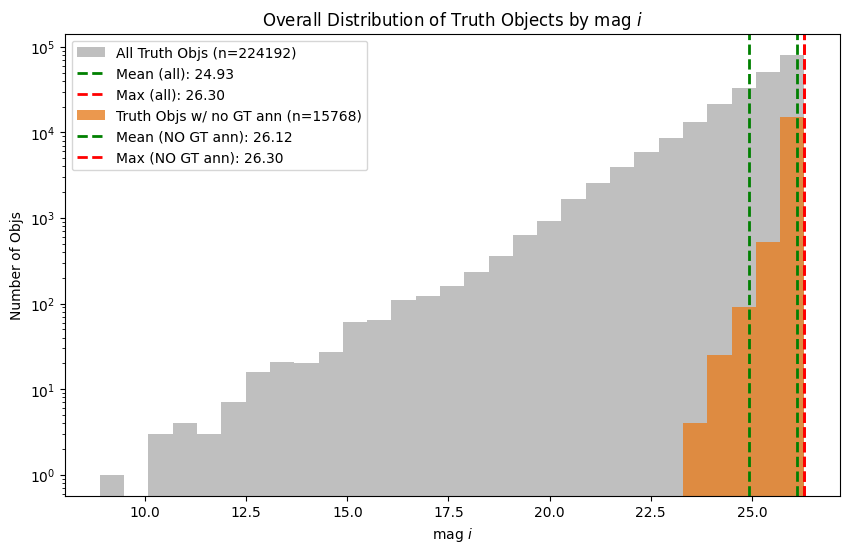

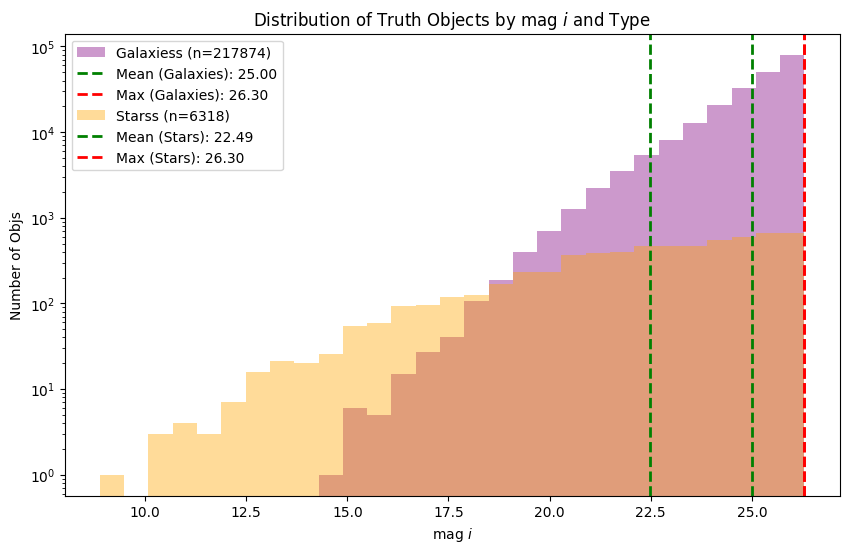

In [8]:
lsst_truth_cat_mags_i = lsst_truth_cat['mag_i'].values
lsst_truth_cat_mags_i_no_ann = lsst_truth_cat[lsst_truth_cat['segmentation'].isna()]['mag_i'].values

bins_full = np.linspace(min(lsst_truth_cat_mags_i), max(lsst_truth_cat_mags_i), 30)
bins_noanns = np.linspace(min(lsst_truth_cat_mags_i_no_ann), max(lsst_truth_cat_mags_i_no_ann), 30)
bins_to_use = bins_full if (bins_full[-1] - bins_full[0]) > (bins_noanns[-1] - bins_noanns[0]) else bins_noanns

cs = {
    'test': '#e67e22',   # orange
    'stars': '#e74c3c',  # red
    'galaxies': '#3498db',  # blue
}
fig, ax = plt.subplots(figsize=(10, 6))
title = r'Overall Distribution of Truth Objects by mag $i$'
# Plot both datasets with different alpha and stat labels
plot_hist(ax, lsst_truth_cat_mags_i, bins=bins_to_use, color='gray', 
          label=f'All Truth Objs (n={len(lsst_truth_cat_mags_i)})', 
          show_stats=True, alpha=0.5, stat_suffix=' (all)')
plot_hist(ax, lsst_truth_cat_mags_i_no_ann, bins=bins_to_use, color=cs['test'], 
          label=f'Truth Objs w/ no GT ann (n={len(lsst_truth_cat_mags_i_no_ann)})', 
          title=title, show_stats=True, alpha=0.8, stat_suffix=' (NO GT ann)')
fig2, ax2 = plt.subplots(figsize=(10, 6))

title = r'Distribution of Truth Objects by mag $i$ and Type'
for cls, label, color in zip([1, 2], ['Galaxies', 'Stars'], ['purple', 'orange']):
    class_mask = (lsst_truth_cat['truth_type'] == cls) & np.isfinite(lsst_truth_cat['mag_i'])
    mags = lsst_truth_cat.loc[class_mask, 'mag_i'].values
    plot_hist(ax2, mags, bins=bins_to_use, color=color, 
            label=f'{label}s (n={len(mags)})', 
            title=title, show_stats=True, alpha=0.4, stat_suffix=f' ({label})')

In [9]:
print(f"{lsst_truth_cat['segmentation'].isna().sum()/len(lsst_truth_cat) * 100:.2f}% ({lsst_truth_cat['segmentation'].isna().sum()}/{len(lsst_truth_cat)}) of objects in our LSST truth catalog don't have ground truth annotations. \n \
      For more info on what type of objects these are, refer to the test_cats notebook.")
lsst_truth_cat[lsst_truth_cat['segmentation'].isna()]['truth_type'].value_counts()

7.03% (15768/224192) of objects in our LSST truth catalog don't have ground truth annotations. 
       For more info on what type of objects these are, refer to the test_cats notebook.


truth_type
1    15622
2      146
Name: count, dtype: int64

## LSST Detection and DeepDISC Detection Catalogs

In [6]:
pred_fn = f'{run_dir}preds/pred_with_mag_s{test_score_thresh}_n{nms_thresh}.json'
with open(pred_fn, 'r') as f:
    dd_det = json.load(f)
dd_det_cat = pd.DataFrame(dd_det)

In [12]:
{col: col for col in dd_det_cat.columns}

{'id': 'id',
 'ra': 'ra',
 'dec': 'dec',
 'class': 'class',
 'file_name': 'file_name',
 'bbox': 'bbox',
 'score': 'score',
 'rle_masks': 'rle_masks',
 'mag_u': 'mag_u',
 'mag_g': 'mag_g',
 'mag_r': 'mag_r',
 'mag_i': 'mag_i',
 'mag_z': 'mag_z',
 'mag_y': 'mag_y'}

In [7]:
lsst_det_cat = pd.read_json(f'{test_cats_dir}test_det_cat.json')

In [11]:
lsst_det_cat

,clean,mag_y,psf_fwhm_r,patch,mag_g,snr_y_cModel,snr_i_cModel,extendedness,mag_z_cModel,mag_u,...,psFlux_y,psFlux_i,psFlux_flag_i,psFluxErr_u,psFluxErr_i,psFlux_flag_r,psFlux_z,psFlux_flag_g,psFluxErr_y,psFluxErr_r
0,True,26.054455,0.839360,"6,2",26.391528,1.372450,7.986091,0.0,25.115672,26.035569,...,137.473151,187.999663,False,32.360671,23.595437,False,318.811900,False,141.671744,12.289870
1,True,26.667179,0.836192,"6,2",28.294721,0.410546,5.409555,1.0,26.385419,31.735020,...,78.185926,126.349621,False,31.193805,23.716334,False,57.875292,False,142.150040,12.345701
2,True,23.936885,0.833364,"6,2",26.123854,6.848957,30.585702,1.0,23.963736,26.357919,...,966.598300,722.682427,False,30.990872,23.633574,False,841.039556,False,142.788712,12.284739
3,True,23.860131,0.833865,"6,2",25.951169,8.531146,15.419505,1.0,23.792243,25.744292,...,1037.402854,332.111273,False,31.341562,23.582971,False,604.357679,False,142.209706,12.369967
4,True,NaN,0.836197,"6,2",25.781982,-0.727757,6.410049,1.0,26.214673,26.471734,...,-78.822508,141.965248,False,31.264371,23.755299,False,119.594758,False,143.689217,12.379011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270102,True,26.132345,0.837439,"3,4",26.312939,0.948628,3.461150,1.0,27.125819,26.967916,...,127.956445,84.080833,False,30.017054,23.272279,False,49.115154,False,131.126425,12.173479
270103,True,24.768463,0.839339,"3,4",25.539306,3.527315,11.364457,1.0,25.243289,25.266529,...,449.380905,265.718373,False,31.411536,23.319767,False,291.680293,False,130.997853,12.140590
270104,True,30.346829,0.839340,"3,4",26.752295,NaN,4.967199,1.0,NaN,26.895290,...,2.637961,115.171969,False,30.964624,23.300253,False,1.231965,False,130.771485,12.138144
270105,True,NaN,0.839339,"3,4",26.888039,NaN,3.755131,1.0,25.989924,NaN,...,-1.696022,88.535890,False,30.966545,23.254910,False,122.757510,False,131.025411,12.142344


In [16]:
dd_det_cat

,id,ra,dec,class,file_name,bbox,score,rle_masks,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y
0,0,53.666271,-41.221835,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[42.8989448547, 17.9103546143, 65.6764068604, ...",0.999335,"{'size': [150, 147], 'counts': 'Tm65_44M2N2O0O...",24.178501,24.361794,24.417967,24.268442,24.298439,23.601818
1,1,53.666430,-41.216028,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[41.8397254944, 122.4864425659, 64.3901672363,...",0.996113,"{'size': [150, 147], 'counts': 'hk64`45L2N101N...",24.193335,24.437212,24.034464,23.551100,23.028345,22.912689
2,2,53.665345,-41.220572,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[56.9977416992, 41.7607955933, 77.0943450928, ...",0.994500,"{'size': [150, 147], 'counts': 'UT96_42N2O1N10...",26.306913,26.051395,25.227131,24.238522,23.961708,23.851330
3,3,53.662491,-41.215551,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[97.684387207, 133.7821044922, 115.3895263672,...",0.991342,"{'size': [150, 147], 'counts': '`R?4a43M10001O...",26.619596,25.951719,25.406775,24.823856,24.747644,25.740545
4,4,53.663421,-41.217250,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[83.0696029663, 100.6747665405, 104.236579895,...",0.988886,"{'size': [150, 147], 'counts': 'Xk<3a45L2N101N...",24.696024,24.835098,24.742519,24.630798,24.255783,23.613699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291259,291259,51.387144,-39.274313,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[113.2707748413, 129.224822998, 127.2647018433...",0.630431,"{'size': [144, 147], 'counts': 'Zg`01Z45000MhK...",26.719328,27.458334,27.033850,27.349329,27.236979,25.773390
291260,291260,51.385543,-39.274108,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[138.3282623291, 135.4037475586, 146.819656372...",0.527945,"{'size': [144, 147], 'counts': 'mWd02]42OO2NdK'}",NaN,28.596455,27.880468,27.188671,27.090696,26.914551
291261,291261,51.394556,-39.278706,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[11.4410963058, 51.4935569763, 22.4649963379, ...",0.456089,"{'size': [144, 147], 'counts': 'hY23]4000Xna0'}",NaN,28.679873,28.023996,28.183262,28.777231,27.536844
291262,291262,51.386813,-39.279414,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[119.1473388672, 38.5061416626, 130.5223999023...",0.400682,"{'size': [144, 147], 'counts': 'kZa02]42O01Oeh2'}",27.515423,28.312260,27.774233,27.715658,NaN,NaN


(-41.695, -41.715)

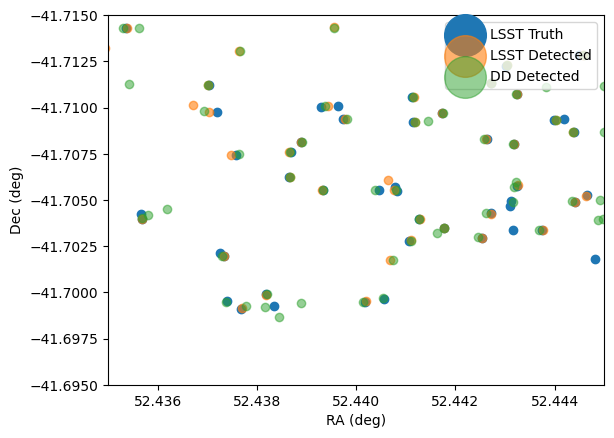

In [13]:
plt.scatter(lsst_truth_cat['ra'], lsst_truth_cat['dec'], label='LSST Truth')
plt.scatter(lsst_det_cat['ra'], lsst_det_cat['dec'], label='LSST Detected', alpha=0.6)
plt.scatter(dd_det_cat['ra'], dd_det_cat['dec'], label='DD Detected', alpha=0.5)
# plt.scatter(lsst_truth_cat['ra'], lsst_truth_cat['dec'], s=1, label='LSST Truth')
# plt.scatter(lsst_det_cat['ra'], lsst_det_cat['dec'], s=1, label='LSST Detected', alpha=0.6)
# plt.scatter(dd_det_cat['ra'], dd_det_cat['dec'], s=1, label='DD Detected', alpha=0.5)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.legend(markerscale=5, loc='upper right')
# plt.xlim(51.81,51.82)
# plt.ylim(-41.62,-41.64)
plt.xlim(52.435,52.445)
plt.ylim(-41.695,-41.715)

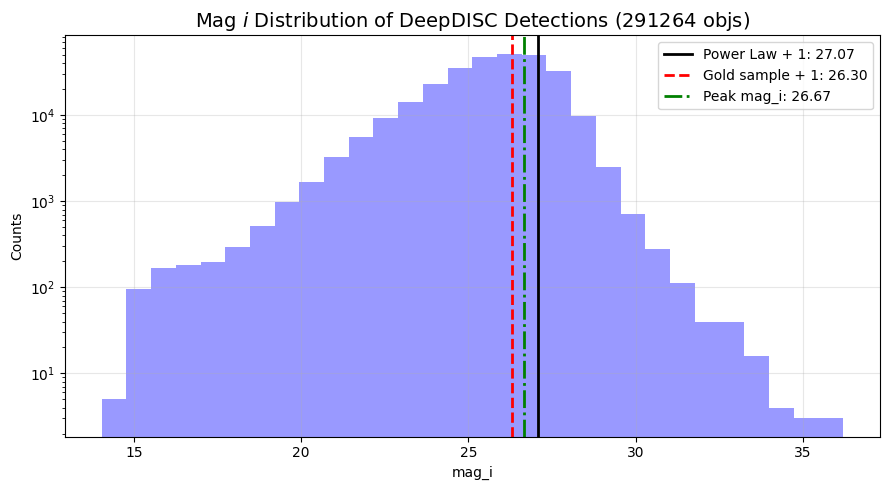

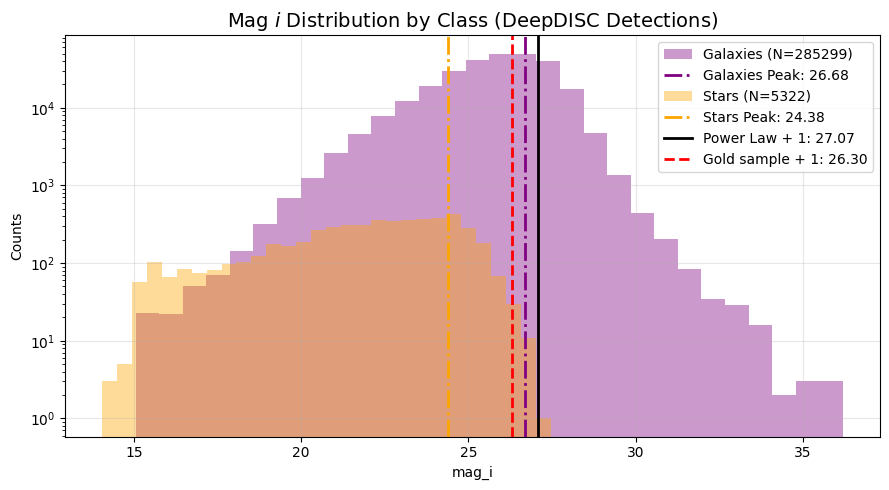

In [19]:
counts, bin_edges = np.histogram(dd_det_cat[np.isfinite(dd_det_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.axvline(peak_mag, color='green', linestyle='-.', linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
plt.hist(dd_det_cat['mag_i'].values, bins=30, alpha=0.4, color='blue')
plt.xlabel('mag_i')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title(f"Mag $i$ Distribution of DeepDISC Detections ({len(dd_det_cat)} objs)", fontsize=14)
plt.tight_layout()

plt.figure(figsize=(9, 5))
for cls, label, color in zip([0, 1], ['Galaxies', 'Stars'], ['purple', 'orange']):
    class_mask = (dd_det_cat['class'] == cls) & np.isfinite(dd_det_cat['mag_i'])
    mags = dd_det_cat.loc[class_mask, 'mag_i'].values
    counts, bin_edges = np.histogram(mags, bins=50)
    peak_bin_index = np.argmax(counts)
    peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
    plt.hist(mags, bins=30, alpha=0.4, color=color, label=f"{label} (N={len(mags)})")
    plt.axvline(peak_mag, color=color, linestyle='-.', linewidth=2, label=f'{label} Peak: {peak_mag:.2f}')

plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.xlabel('mag_i')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title("Mag $i$ Distribution by Class (DeepDISC Detections)", fontsize=14)
plt.tight_layout()

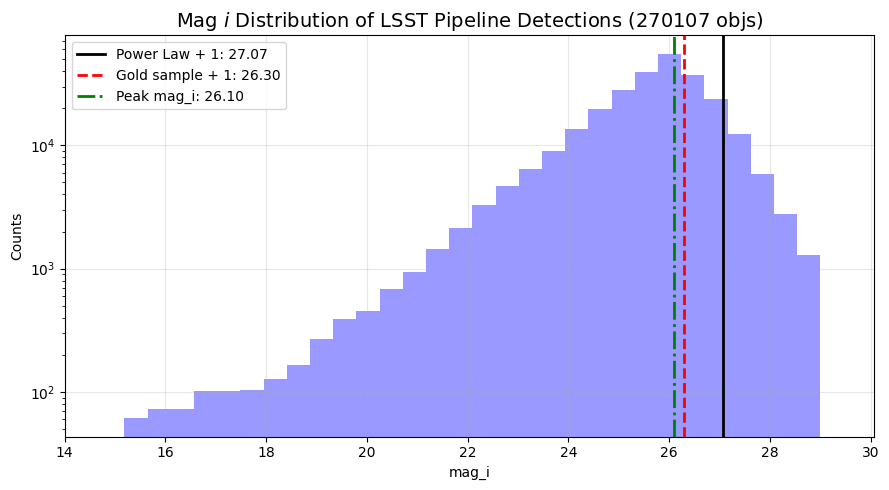

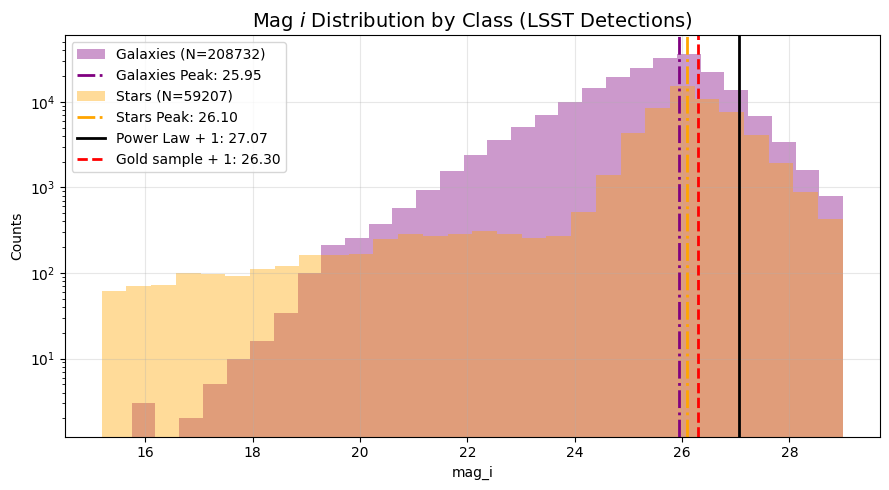

In [21]:
counts, bin_edges = np.histogram(lsst_det_cat[np.isfinite(lsst_det_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.axvline(peak_mag, color='green', linestyle='-.', linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
plt.hist(lsst_det_cat['mag_i'].values, bins=30, alpha=0.4, color='blue')
plt.xlabel('mag_i')
plt.xlim(14, mag_limits['power_law'] + buffers[0] + 3)
plt.ylabel('Counts')
# plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title(f"Mag $i$ Distribution of LSST Pipeline Detections ({len(lsst_det_cat)} objs)", fontsize=14)
plt.tight_layout()


plt.figure(figsize=(9, 5))
for cls, label, color in zip([1, 0], ['Galaxies', 'Stars'], ['purple', 'orange']):
    class_mask = (lsst_det_cat['extendedness'] == cls) & np.isfinite(lsst_det_cat['mag_i'])
    mags = lsst_det_cat.loc[class_mask, 'mag_i'].values
    counts, bin_edges = np.histogram(mags, bins=50)
    peak_bin_index = np.argmax(counts)
    peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
    plt.hist(mags, bins=30, alpha=0.4, color=color, label=f"{label} (N={len(mags)})")
    plt.axvline(peak_mag, color=color, linestyle='-.', linewidth=2, label=f'{label} Peak: {peak_mag:.2f}')

plt.axvline(mag_limits['power_law'] + buffers[0], color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limits["power_law"] + buffers[0]:.2f}')
plt.axvline(mag_limits['gold'] + buffers[0], color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {mag_limits["gold"] + buffers[0]:.2f}')
plt.xlabel('mag_i')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title("Mag $i$ Distribution by Class (LSST Detections)", fontsize=14)
plt.tight_layout()

## Mag Distribution of All Catalogs

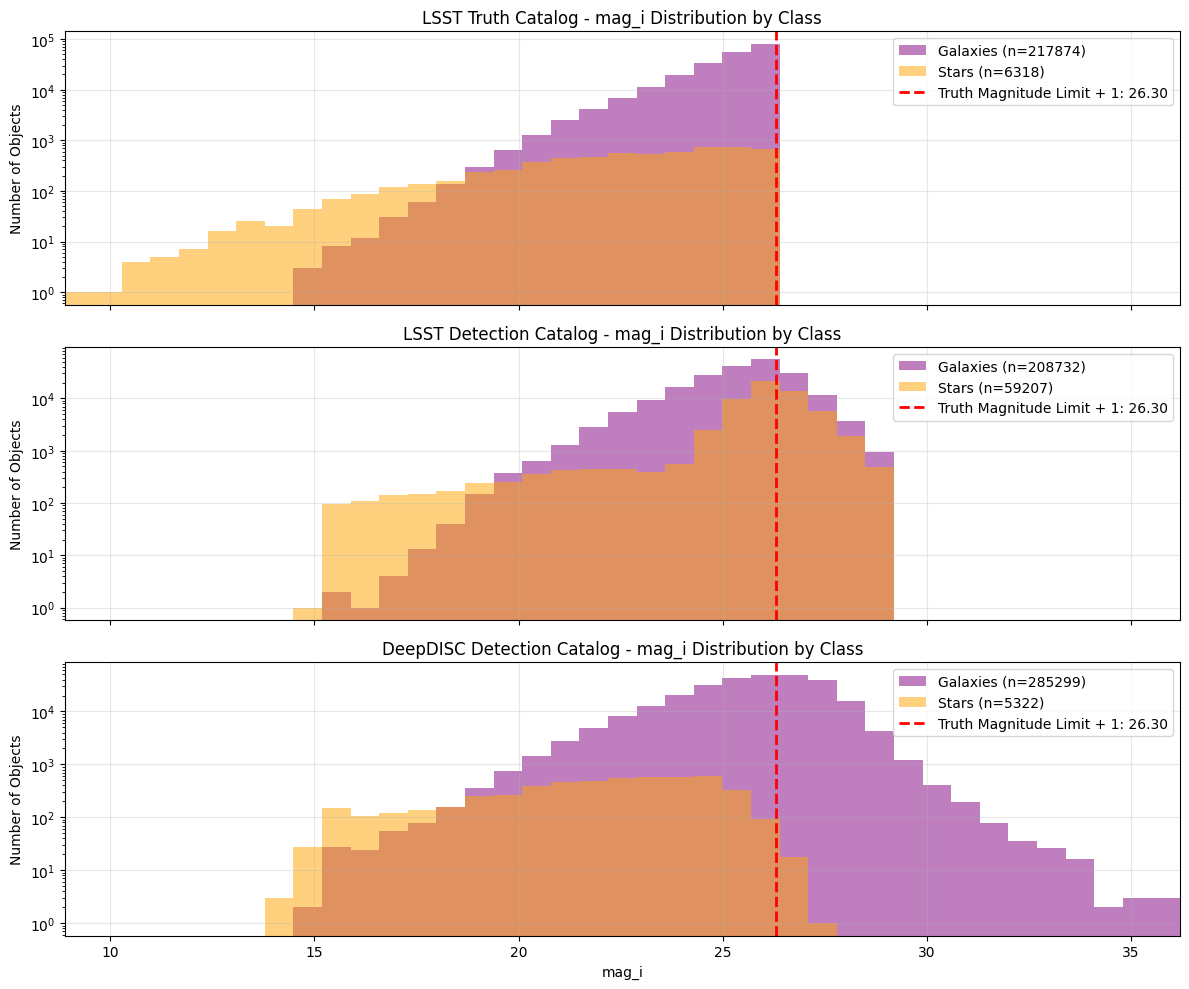

In [13]:
all_mags = np.concatenate([
    lsst_truth_cat[np.isfinite(lsst_truth_cat['mag_i'])]['mag_i'].values,
    lsst_det_cat[np.isfinite(lsst_det_cat['mag_i'])]['mag_i'].values,
    dd_det_cat[np.isfinite(dd_det_cat['mag_i'])]['mag_i'].values
])
mag_min, mag_max = np.nanmin(all_mags), np.nanmax(all_mags)
common_bins = np.linspace(mag_min, mag_max, 40)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# catalogs: (data, title, class_pairs, class_column)
viz_cats = [
    (lsst_truth_cat, 'LSST Truth Catalog', [(1, 'Galaxies', 'purple'), (2, 'Stars', 'orange')], 'truth_type'),
    (lsst_det_cat, 'LSST Detection Catalog', [(1, 'Galaxies', 'purple'), (0, 'Stars', 'orange')], 'extendedness'),
    (dd_det_cat, 'DeepDISC Detection Catalog', [(0, 'Galaxies', 'purple'), (1, 'Stars', 'orange')], 'class')
]
for idx, (catalog, title, class_pairs, class_column) in enumerate(viz_cats):
    ax = axes[idx]
    for cls, label, color in class_pairs:
        class_mask = (catalog[class_column] == cls) & np.isfinite(catalog['mag_i'])
        mags = catalog.loc[class_mask, 'mag_i'].values
        ax.hist(mags, bins=common_bins, alpha=0.5, color=color, label=f'{label} (n={len(mags)})')
    # Add truth mag limit line
    ax.axvline(truth_mag_limit, color='red', linestyle='--', linewidth=2, 
               label=f'Truth Magnitude Limit + 1: {truth_mag_limit:.2f}')
    ax.set_ylabel('Number of Objects')
    if idx == 2:
        ax.set_xlabel('mag_i')
    ax.set_title(f'{title} - mag_i Distribution by Class', fontsize=12)
    ax.legend(loc='upper right')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)

axes[0].set_xlim(mag_min, mag_max)
plt.tight_layout()

# FOF Catalog Matching w/ Detection and Truth Catalogs

The below approach is loosely based on Liang's 2025 et al. (*Catalog-based Detection of Unrecognized Blends in Deep Optical Ground Based Catalogs*) matching criteria in 2.3.

We will use the [FOFCatalogMatching](https://github.com/yymao/FoFCatalogMatching/tree/master) package which uses the friends-of-friends method to iteratively match multiple sky catalogs without the need of specifying the main catalog. As such, we will be matching DeepDISC detections with the LSST ground truth catalog and the LSST pipeline detections to the LSST ground truth catalog with linking lengths of 1.0" and 2.0" and max_friends set to None. It's important that we set max_friends to None because we want to know if one DeepDISC detection corresponds to 2,3 or even 4 truth objects. So, if we set a limit to max_friends, we artifically force the algorithm to ignore complex blends and potentially misclassify them. 

To figure out exactly how many pixels these linking lengths correspond to, we can use the formula:

$$ \text{pixels} = \frac{\text{angular size (arcsec)}}{\text{pixel scale (arcsec/pixel)}} $$

We know LSST's pixel scale is 0.2 arcsec/pixel, so $(1.0/0.2) = 5.0 $ and $ (2.0/0.2) = 10 $ px. So 1.0" corresponds to 5 pixels, and 2.0" corresponds to 10.0 pixels.  

<!-- 
To be considered a "valid" detection (recovered from the truth catalog), the source must meet these two criteria:
- Detection must be within 1" of a truth object
- If multiple truth objects are within 1", the match is assigned to the truth object that is the closest in magnitude (considering all nearest neighbors).

To achieve this, we will use `search_around_sky` which will find all the matches within a given radius. Then, we group all the truth matches for the same detection and sort them based on the detection's observed mag and the truth match's mag. Since it's all sorted now, to keep the best match, we simply drop all the duplicates and keep the first occurrence. -->

In [8]:
# points within 1 arcsecs of each other are grouped together only if there's no more than 3 friends within 1 arcsec
# None following distance means points are grouped together without any constraint on number of friends
def find_matches(cats, linking_length=1.0, max_friends=None):
    """
    Find matches between two catalogs using FOF algo.
    
    Parameters:
    -----------
    cat_a, cat_b : pd.DataFrame or astropy.table.Table
        The two catalogs to match. Should have 'ra' and 'dec' columns.
    cat_a_name, cat_b_name : str
        Names for the two catalogs.
    linking_length : float, optional
        The linking length in arcseconds. Default is 1.0.
    max_friends : int or None, optional
        Maximum num of friends allowed in a group. 
        Use None for no limit. Default is 1.
    
    Returns:
    --------
    astropy.table.Table
        Matched catalog with group IDs.
    """
    print(f"Processing {len(cats)} catalogs:", cats.keys())
    # FOF matching needs astropy tables so we convert to tables if they're dfs 
    cat_tables = {}
    for name, cat in cats.items():
        if isinstance(cat, pd.DataFrame):
            cat_tables[name] = Table.from_pandas(cat[['ra', 'dec']])
        else:
            cat_tables[name] = cat
    linking_lengths = {linking_length: max_friends}
    return FoFCatalogMatching.match(
        cat_tables,
        linking_lengths
    )

In [ ]:
lsst_cats = {
    'lsst_det': lsst_det_cat,
    'lsst_truth': lsst_truth_cat,
}
dd_cats = {
    'dd_det': dd_det_cat,
    'lsst_truth': lsst_truth_cat,
}

In [41]:
results1_dd = find_matches(
    dd_cats,
    linking_length=1.0,
    max_friends=None,
) 
results1_lsst = find_matches(
    lsst_cats,
    linking_length=1.0,
    max_friends=None,
)
# took 45s w/ gold mag
results1_dd

Processing 2 catalogs: dict_keys(['dd_det', 'lsst_truth'])
Processing 2 catalogs: dict_keys(['lsst_det', 'lsst_truth'])


row_index,catalog_key,group_id
int64,str10,int64
0,dd_det,0
15,lsst_truth,0
1,dd_det,1
1,lsst_truth,1
2,dd_det,2
9,lsst_truth,2
3,dd_det,3
7,lsst_truth,3
4,dd_det,4


In [43]:
results2_dd = find_matches(
    dd_cats,
    linking_length=2.0,
    max_friends=None,
) 
results2_lsst = find_matches(
    lsst_cats,
    linking_length=2.0,
    max_friends=None,
)
# took s w/ gold mag
results2_dd

Processing 2 catalogs: dict_keys(['dd_det', 'lsst_truth'])
Processing 2 catalogs: dict_keys(['lsst_det', 'lsst_truth'])


row_index,catalog_key,group_id
int64,str10,int64
0,dd_det,0
15,lsst_truth,0
1,dd_det,1
18,dd_det,1
1,lsst_truth,1
2,lsst_truth,1
2,dd_det,2
9,lsst_truth,2
3,dd_det,3


Let's understand what each column in the results_1 table means:
- `row_index` is the integer idx of the object in the OG source catalog. For example, `row_index=12` and `catalog_key='lsst_det'` refers to the object located at the 12th row of our original `lsst_det_cat` catalog. We can use this to map object properties to these match results.
- `catalog_key` explains which catalog the object originated from
- `group_id` is a unique identifier for a cluster of objects and all objects sharing the same `group_id` are considered friends AKA "matched". For example, as you can see above, Group 0 contains one DeepDISC detection, one LSST detection, and one LSST truth object. This is a successful, isolated detection for both DeepDISC and the LSST pipeline. There could also be groups where the group only contains an object from the truth catalog which implies a missed detection from both DeepDISC and the LSST pipeline. 

In [44]:
results = {
    "dd": {
        "1.0": results1_dd,
        "2.0": results2_dd,
    },
    "lsst": {
        "1.0": results1_lsst,
        "2.0": results2_lsst,
    }
}

In [45]:
# loop over results and save each
for cat_type, res_dict in results.items():
    for ll, res in res_dict.items():
        res.write(f'/u/yse2/lsst_runs/{run_name}/results{cat_type}_{ll}_{truth_mag_limit}.ecsv', overwrite=True)

In [10]:
# skip here to re-load saved results (but make sure to set truth_mag_limit correctly)
results = {'dd': {}, 'lsst': {}}
for cat_type in ['dd', 'lsst']:
    for ll in ['1.0', '2.0']:
        results[cat_type][ll] = Table.read(f'/u/yse2/lsst_runs/{run_name}/results{cat_type}_{ll}_{truth_mag_limit}.ecsv')

In [11]:
results

{'dd': {'1.0': <Table length=515456>
  row_index catalog_key group_id
    int64      str10     int64  
  --------- ----------- --------
          0      dd_det        0
         15  lsst_truth        0
          1      dd_det        1
          1  lsst_truth        1
          2      dd_det        2
          9  lsst_truth        2
          3      dd_det        3
          7  lsst_truth        3
          4      dd_det        4
        ...         ...      ...
     224129  lsst_truth   291149
     224144  lsst_truth   291150
     224147  lsst_truth   291151
     224150  lsst_truth   291152
     224151  lsst_truth   291153
     224152  lsst_truth   291154
     224153  lsst_truth   291155
     224160  lsst_truth   291156
     224162  lsst_truth   291157
     224171  lsst_truth   291158,
  '2.0': <Table length=515456>
  row_index catalog_key group_id
    int64      str10     int64  
  --------- ----------- --------
          0      dd_det        0
         15  lsst_truth        0
       

In [12]:
results_dd_df = {
    ll: res.to_pandas() for ll, res in results['dd'].items()
}
results_lsst_df = {
    ll: res.to_pandas() for ll, res in results['lsst'].items()
}

## Creating Obj Info Table

In [14]:
def build_table(results_df, cats, col_config):
    """
    Builds a long-format table by joining requested cols from source cats
    Args:
        results_df: The matched results (row_index, catalog_key, group_id) from FOF matching
        cats: Dict of source cats (e.g., {'dd_det': dd_cat, 'lsst_truth': truth_cat}).
        col_config: Dict defining which cols to grab and how to rename them.
                    Format: {'catalog_key': {'orig_col_name': 'new_col_name'}}
    """
    chunks = []
    # iter thru unique cat keys present in results (e.g., 'dd_det', 'lsst_truth')
    for cat_key in results_df['catalog_key'].unique():
        if cat_key not in cats:
        # in the future, could add more cats (like roman det and roman truth)
            print(f"Didn't recognize catalog key: {cat_key}, skipping...")
            continue
        # grabbing subset of results for this specific cat_key
        subset = results_df[results_df['catalog_key'] == cat_key].copy()
        source_cat = cats[cat_key]
        config = col_config.get(cat_key, {})
        print(f"Processing {len(subset)} entries for catalog key: {cat_key}")
        print(f"Config columns: {config}")
        # select only cols we need from the source cat (listed in our config keys)
        cols_to_fetch = list(config.keys())
        if not cols_to_fetch:
            # If no cols requested for this cat, just keep the IDs
            chunks.append(subset)
            continue
        # now we merge which replaces idxing into the catalog manually
        merged = subset.merge(
            source_cat[cols_to_fetch],
            left_on='row_index',   # idx stored in results
            right_index=True,      # actual idx of source catalog
            how='left'
        )
        # rename cols so they align (e.g. objectId -> id)
        merged.rename(columns=config, inplace=True)
        chunks.append(merged)
    
    # combine everything back together
    final_df = pd.concat(chunks, axis=0).reset_index(drop=True)
    return final_df

In [15]:
dd_cats['dd_det'].columns

Index(['id', 'ra', 'dec', 'class', 'file_name', 'bbox', 'score', 'rle_masks',
       'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y'],
      dtype='object')

In [29]:
print(lsst_det_cat.columns)

Index(['clean', 'mag_y', 'psf_fwhm_r', 'patch', 'mag_g', 'snr_y_cModel',
       'snr_i_cModel', 'extendedness', 'mag_z_cModel', 'mag_u',
       ...
       'psFlux_y', 'psFlux_i', 'psFlux_flag_i', 'psFluxErr_u', 'psFluxErr_i',
       'psFlux_flag_r', 'psFlux_z', 'psFlux_flag_g', 'psFluxErr_y',
       'psFluxErr_r'],
      dtype='object', length=139)


In [30]:
print(lsst_truth_cat.columns)

Index(['id', 'mag_r', 'patch', 'flux_g', 'tract', 'mag_z', 'dec', 'mag_y',
       'rv', 'ra', 'cosmodc2_hp', 'av', 'mag_g', 'mag_u', 'flux_z',
       'host_galaxy', 'flux_i', 'truth_type', 'flux_r', 'cosmodc2_id',
       'flux_y', 'mag_i', 'id_string', 'flux_u', 'redshift',
       'ellipticity_2_disk_true', 'position_angle_true',
       'ellipticity_1_bulge_true', 'bulge_to_total_ratio_i', 'shear_1',
       'SDSS_filters/diskLuminositiesStellar:SDSS_r:observed',
       'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed',
       'ellipticity_1_disk_true', 'mag_true_y',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed',
       'mag_true_i', 'size_minor_true', 'R_v', 'size_minor_disk_true',
       'size_minor_bulge_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_u:observed',
       'SDSS_filters/diskLuminositiesStellar:SDSS_z:observed',
       'position_angle_true_dc2', 'size_bulge_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed',
      

In [16]:
# cols we want to pull from each cat {'og_col_name': 'new_col_name'}
config = {
    # copy all cols
    'dd_det': {col: col for col in dd_cats['dd_det'].columns},
    'lsst_det': {
        'objectId': 'id',  # rename to match DD and LSST truth's 'id'
        'parentObjectId': 'parentObjectId',
        'ra': 'ra',
        'dec': 'dec',
        'tract': 'tract',
        'patch': 'patch',
        'Ixx_pixel': 'Ixx_pixel',
        'Iyy_pixel': 'Iyy_pixel',
        'Ixy_pixel': 'Ixy_pixel',
        'I_flag': 'I_flag',
        'IxxPSF_pixel': 'IxxPSF_pixel',
        'IyyPSF_pixel': 'IyyPSF_pixel',
        'IxyPSF_pixel': 'IxyPSF_pixel',
        # ideally separate mags for stars and galaxies (use mag_i_cModel for galaxies but ~300 galaxies have NaN cModel mag_i)
        'mag_u': 'mag_u',
        'mag_g': 'mag_g',
        'mag_r': 'mag_r',
        'mag_i': 'mag_i',
        'mag_z': 'mag_z',
        'mag_y': 'mag_y', 
        'psFlux_u': 'psFlux_u',
        'psFlux_g': 'psFlux_g',
        'psFlux_r': 'psFlux_r',
        'psFlux_i': 'psFlux_i',
        'psFlux_z': 'psFlux_z',
        'psFlux_y': 'psFlux_y',
        'cModelFlux_u': 'cModelFlux_u',
        'cModelFlux_g': 'cModelFlux_g',
        'cModelFlux_r': 'cModelFlux_r',
        'cModelFlux_i': 'cModelFlux_i',
        'cModelFlux_z': 'cModelFlux_z',
        'cModelFlux_y': 'cModelFlux_y',
        'snr_u_cModel': 'snr_u',
        'snr_g_cModel': 'snr_g',
        'snr_r_cModel': 'snr_r',
        'snr_i_cModel': 'snr_i',
        'snr_z_cModel': 'snr_z',
        'snr_y_cModel': 'snr_y',
        'psf_fwhm_u': 'psf_fwhm_u',
        'psf_fwhm_g': 'psf_fwhm_g',
        'psf_fwhm_r': 'psf_fwhm_r',
        'psf_fwhm_i': 'psf_fwhm_i',
        'psf_fwhm_z': 'psf_fwhm_z',
        'psf_fwhm_y': 'psf_fwhm_y',
        'extendedness': 'class', # rename to 'class' to match DD (0 is star, 1 is galaxy)
        'blendedness': 'blendedness',
        'x': 'x',
        'y': 'y',
        'cutout_x': 'cutout_x',
        'cutout_y': 'cutout_y',
        'file_name': 'file_name'
    },
    'lsst_truth': {
        'id': 'id',
        'ra': 'ra',
        'dec': 'dec',
        'truth_type': 'class',  # rename to match DD (2 is star, 1 is galaxy)
        'tract': 'tract',
        'patch': 'patch',
        'mag_u': 'mag_u',
        'mag_g': 'mag_g',
        'mag_r': 'mag_r',
        'mag_i': 'mag_i',
        'mag_z': 'mag_z',
        'mag_y': 'mag_y',
        'flux_u': 'flux_u',
        'flux_g': 'flux_g',
        'flux_r': 'flux_r',
        'flux_i': 'flux_i',
        'flux_z': 'flux_z',
        'flux_y': 'flux_y',
        # sizes
        'size_true': 'size',
        'size_disk_true': 'size_disk',
        'size_bulge_true': 'size_bulge',
        'size_minor_true': 'size_minor',
        'size_minor_disk_true': 'size_minor_disk',
        'size_minor_bulge_true': 'size_minor_bulge',
        # ellipticity
        'ellipticity_1_true': 'e1',
        'ellipticity_2_true': 'e2',
        'ellipticity_1_disk_true': 'e1_disk',
        'ellipticity_2_disk_true': 'e2_disk',
        'ellipticity_1_bulge_true': 'e1_bulge',
        'ellipticity_2_bulge_true': 'e2_bulge',
        # orientation & profile
        'position_angle_true': 'pa_true',
        'position_angle_true_dc2': 'pa_true_dc2',
        'bulge_to_total_ratio_u': 'bttr_u',
        'bulge_to_total_ratio_g': 'bttr_g',
        'bulge_to_total_ratio_r': 'bttr_r',
        'bulge_to_total_ratio_i': 'bttr_i',
        'bulge_to_total_ratio_z': 'bttr_z',
        'bulge_to_total_ratio_y': 'bttr_y',
        # dust/extinction
        'av': 'av',
        'A_v': 'A_v',
        'rv': 'rv',
        'R_v': 'R_v',
        # SDSS filter luminosities (stellar)
        'SDSS_filters/diskLuminositiesStellar:SDSS_u:observed': 'SDSS_diskLum_u',
        'SDSS_filters/diskLuminositiesStellar:SDSS_g:observed': 'SDSS_diskLum_g',
        'SDSS_filters/diskLuminositiesStellar:SDSS_r:observed': 'SDSS_diskLum_r',
        'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed': 'SDSS_diskLum_i',
        'SDSS_filters/diskLuminositiesStellar:SDSS_z:observed': 'SDSS_diskLum_z',
        'SDSS_filters/spheroidLuminositiesStellar:SDSS_u:observed': 'SDSS_spheroidLum_u',
        'SDSS_filters/spheroidLuminositiesStellar:SDSS_g:observed': 'SDSS_spheroidLum_g',
        'SDSS_filters/spheroidLuminositiesStellar:SDSS_r:observed': 'SDSS_spheroidLum_r',
        'SDSS_filters/spheroidLuminositiesStellar:SDSS_i:observed': 'SDSS_spheroidLum_i',
        'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed': 'SDSS_spheroidLum_z',
        # LSST filter luminosities (stellar)
        'LSST_filters/diskLuminositiesStellar:LSST_u:observed': 'LSST_diskLum_u',
        'LSST_filters/diskLuminositiesStellar:LSST_y:observed': 'LSST_diskLum_y',
        'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed': 'LSST_spheroidLum_u',
        'LSST_filters/spheroidLuminositiesStellar:LSST_y:observed': 'LSST_spheroidLum_y',
        'shear_1': 'shear_1',
        'shear_2': 'shear_2',
        'convergence': 'convergence',
        'host_galaxy': 'host_galaxy',
        'cosmodc2_hp': 'cosmodc2_hp',
        'cosmodc2_id': 'cosmodc2_id',
        'redshift': 'z',
        # Cutout info
        'image_id': 'image_id',
        'height': 'height',
        'width': 'width',
        'tile': 'tile',
        'det_cat_path': 'det_cat_path',
        'truth_cat_path': 'truth_cat_path',
        'wcs': 'wcs',
        'bbox': 'bbox',
        'bbox_mode': 'bbox_mode',
        'segmentation': 'segmentation',
        'cutout_x': 'cutout_x',
        'cutout_y': 'cutout_y',
        'file_name': 'file_name'
    }
}

In [53]:
analysis_df_dd = {
    ll: build_table(res_df, dd_cats, config) for ll, res_df in results_dd_df.items()
}
print("\n")
analysis_df_lsst = {
    ll: build_table(res_df, lsst_cats, config) for ll, res_df in results_lsst_df.items()
}

Processing 291264 entries for catalog key: dd_det
Config columns: {'id': 'id', 'ra': 'ra', 'dec': 'dec', 'class': 'class', 'file_name': 'file_name', 'bbox': 'bbox', 'score': 'score', 'rle_masks': 'rle_masks', 'mag_u': 'mag_u', 'mag_g': 'mag_g', 'mag_r': 'mag_r', 'mag_i': 'mag_i', 'mag_z': 'mag_z', 'mag_y': 'mag_y'}
Processing 224192 entries for catalog key: lsst_truth
Config columns: {'id': 'id', 'ra': 'ra', 'dec': 'dec', 'truth_type': 'class', 'tract': 'tract', 'patch': 'patch', 'mag_u': 'mag_u', 'mag_g': 'mag_g', 'mag_r': 'mag_r', 'mag_i': 'mag_i', 'mag_z': 'mag_z', 'mag_y': 'mag_y', 'flux_u': 'flux_u', 'flux_g': 'flux_g', 'flux_r': 'flux_r', 'flux_i': 'flux_i', 'flux_z': 'flux_z', 'flux_y': 'flux_y', 'size_true': 'size', 'size_disk_true': 'size_disk', 'size_bulge_true': 'size_bulge', 'size_minor_true': 'size_minor', 'size_minor_disk_true': 'size_minor_disk', 'size_minor_bulge_true': 'size_minor_bulge', 'ellipticity_1_true': 'e1', 'ellipticity_2_true': 'e2', 'ellipticity_1_disk_true'

In [56]:
analysis_df_dd['1.0']
# or if we want a weird object in row 500
# weird_obj = analysis['1.0'].iloc[500]
# idx = weird_obj['row_index']
# cat_type = weird_obj['catalog_key']
# or just manual lookup 
# if cat_type == 'dd_det':
#     print(dd_det_cat.loc[idx])

,row_index,catalog_key,group_id,id,ra,dec,class,file_name,bbox,score,...,height,width,tile,det_cat_path,truth_cat_path,wcs,bbox_mode,segmentation,cutout_x,cutout_y
0,0,dd_det,0,0,53.666271,-41.221835,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[42.8989448547, 17.9103546143, 65.6764068604, ...",0.999335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,dd_det,1,1,53.666430,-41.216028,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[41.8397254944, 122.4864425659, 64.3901672363,...",0.996113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,dd_det,2,2,53.665345,-41.220572,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[56.9977416992, 41.7607955933, 77.0943450928, ...",0.994500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,dd_det,3,3,53.662491,-41.215551,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[97.684387207, 133.7821044922, 115.3895263672,...",0.991342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,dd_det,4,4,53.663421,-41.217250,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[83.0696029663, 100.6747665405, 104.236579895,...",0.988886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515451,224152,lsst_truth,291154,9501967134,53.606061,-41.391987,1,/u/yse2/lsst_data/truth/53.60_-41.4/c202_53.60...,None,NaN,...,NaN,NaN,None,None,None,None,NaN,None,53.715798,115.251188
515452,224153,lsst_truth,291155,9500885879,53.605171,-41.390790,1,/u/yse2/lsst_data/truth/53.60_-41.4/c202_53.60...,None,NaN,...,NaN,NaN,None,None,None,None,NaN,None,65.957175,136.679098
515453,224160,lsst_truth,291156,9503677434,53.606833,-41.397125,1,/u/yse2/lsst_data/truth/53.60_-41.4/c202_53.60...,None,NaN,...,NaN,NaN,None,None,None,None,NaN,None,42.359833,22.879871
515454,224162,lsst_truth,291157,9507863881,53.599440,-41.395396,1,/u/yse2/lsst_data/truth/53.60_-41.4/c202_53.60...,"[135.5, 44.5, 13.0, 15.0]",NaN,...,149.0,148.0,53.60_-41.4,/u/yse2/lsst_data/truth/53.60_-41.4/det_c202_5...,/u/yse2/lsst_data/truth/53.60_-41.4/truth_c202...,WCSAXES = 2 ...,1.0,"[[142, 49, 140, 51, 140, 54, 142, 56, 143, 56,...",142.514070,52.977258


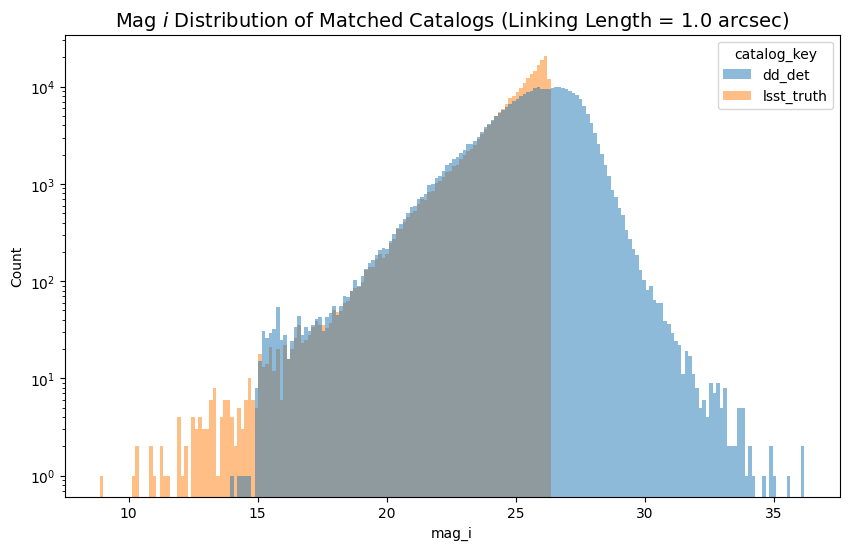

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=analysis_df_dd['1.0'], x='mag_i', bins=200, hue='catalog_key', ax=ax, edgecolor=None)
plt.title(f"Mag $i$ Distribution of Matched Catalogs (Linking Length = 1.0 arcsec)", fontsize=14)
ax.set_yscale('log')

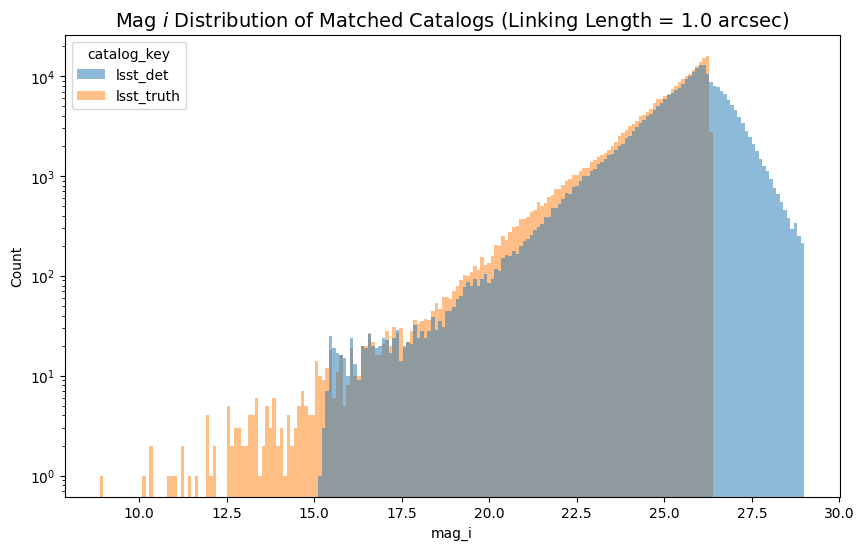

In [58]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=analysis_df_lsst['1.0'], x='mag_i', bins=200, hue='catalog_key', ax=ax, edgecolor=None)
plt.title(f"Mag $i$ Distribution of Matched Catalogs (Linking Length = 1.0 arcsec)", fontsize=14)
ax.set_yscale('log')

In [59]:
analysis_df_dd['1.0'][analysis_df_dd['1.0']['catalog_key'] == 'lsst_truth']['mag_i'].describe()

count    224192.000000
mean         24.930192
std           1.396033
min           8.881651
25%          24.406944
50%          25.363270
75%          25.918063
max          26.299999
Name: mag_i, dtype: float64

## Saving Analysis Tables

In [60]:
for ll, analysis_df in analysis_df_dd.items():
    print(f"Saving DD analysis table for linking length {ll} with {len(analysis_df)} rows...")
    analysis_df.to_parquet(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/analysisdd_{ll}_{truth_mag_limit}.parquet')

for ll, analysis_df in analysis_df_lsst.items():
    print(f"Saving LSST analysis table for linking length {ll} with {len(analysis_df)} rows...")
    analysis_df.to_parquet(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/analysislsst_{ll}_{truth_mag_limit}.parquet')

Saving DD analysis table for linking length 1.0 with 515456 rows...
Saving DD analysis table for linking length 2.0 with 515456 rows...
Saving LSST analysis table for linking length 1.0 with 494299 rows...
Saving LSST analysis table for linking length 2.0 with 494299 rows...


In [48]:
# skip here to re-load saved results (but make sure to set truth_mag_limit correctly)
analysis_df_dd = {}
for ll in ['1.0', '2.0']:
    analysis_df_dd[ll] = pd.read_parquet(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/analysisdd_{ll}_{truth_mag_limit}.parquet')

analysis_df_lsst = {}
for ll in ['1.0', '2.0']:
    analysis_df_lsst[ll] = pd.read_parquet(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/analysislsst_{ll}_{truth_mag_limit}.parquet')


# Classifying Groups

Let's now talk about how we're going to classify these different groups.

## Stage 1 Classification

At this first stage, we assign a preliminary topological classification to the group based on counts. For each resulting FoF group, we calculated the multiplicity of truth objects and detected objects. These classes define the *potential* nature of the detection success or failure (see below).

<!-- We do not know if the positions match. So, we will have *candidate* recovered/partial blends, and *candidate* shreds since the count is correct but we need to confirm the objects' positions. -->

- `n_truth == n_det == 1`: Isolated Match (Truth object matches exactly one detection) 
- `n_truth == n_det, n_det > 1`: Candidate Resolved Blend (Matched count of truth and detected objects 2->2, 3->3)
- `n_truth > n_det, n_det == 0`: Missed detections (Truth object exists but was not detected - False Negatives)
- `n_det > n_truth, n_truth == 0`: Spurious detections (No truth object exists - False Positives)
- `n_truth > n_det, n_det == 1`: Unrecognized Blend (Multiple truth objects detected as one object)
- `n_det > n_truth, n_truth == 1`: Shredded (More detected objects than single truth object)
- `n_truth > n_det > 1`: Complex Merge (More truth objects than detected objects)
- `n_det > n_truth > 1`: Complex Shred (More detected objects than truth objects)


In [6]:
def get_stage1_counts(analysis, expected_keys=None, rename_map=None):
    # group by group_id and catalog_key to get counts
    counts = (
        analysis.groupby(['group_id', 'catalog_key'])
        .size()
        .unstack(fill_value=0)
    )
    # ensure all cols exist (in case a batch has 0 detections total)
    if expected_keys is None:
        expected_keys = ['dd_det', 'lsst_det', 'lsst_truth']
    for col in expected_keys:
        if col not in counts.columns:
            counts[col] = 0
    if rename_map is None:
        rename_map = {
            'lsst_truth': 'n_truth',
            'lsst_det': 'n_lsst',
            'dd_det': 'n_dd'
        }
    counts.rename(columns=rename_map, inplace=True)
    return counts

def classify_stg1(counts, prefix, det_col_name, truth_col_name='n_truth'):
    """
    Applies Stage 1 Classification rules (Counts only) to the dataframe
    Args:
        df: The counts dataframe (from get_stage1_counts)
        prefix: String prefix for the output label column (e.g., 'dd' or 'lsst')
        det_col_name: The column name for detection counts (e.g., 'n_dd')
        truth_col_name: The column name for truth counts (default 'n_truth')
    Returns:
        df: The dataframe with a new column '{prefix}_label_stg1' containing the Stage 1 class.
    """
    label_col = f"{prefix}_stg1"
    n_t = counts[truth_col_name]
    n_d = counts[det_col_name]

    conditions = [
        # n is truth and m is det
        (n_t == 1) & (n_d == 1),    # 1-to-1: isolated match
        (n_t > 1) & (n_d == n_t),   # N-to-N: candidate resolved blend
        (n_t > n_d) & (n_d == 0),     # N-to-0: missed (FN)
        (n_d > n_t) & (n_t == 0),     # 0-to-N: spurious (FP)        
        (n_t > n_d) & (n_d == 1),     # N-to-1: unrecognized blend
        (n_d > n_t) & (n_t == 1),    # 1-to-N: shredded
        (n_t > n_d) & (n_d > 1),     # N-to-M where N > M > 1 (more truth than det)
        (n_d > n_t) & (n_t > 1)      # N-to-M where M > N > 1 (more det than truth)
    ]
    classes = [
        'isolated_match',          
        'candidate_res_blend',     
        'missed_false_neg',        
        'spurious_false_pos',      
        'unrec_blend',   
        'shredded',     
        'complex_merge',   
        'complex_shred'          
    ]

    # n/a in case we missed a case but this shld be impossible
    counts[label_col] = np.select(conditions, classes, default='n/a')
    return counts

In [7]:
counts_dd = {}
counts_lsst = {}
# for each linking length and for each detection pipeline
for ll in ['1.0', '2.0']:
    print(f"Processing for {ll}\" linking length for DeepDISC")
    counts_dd[ll] = get_stage1_counts(
        analysis_df_dd[ll],
        expected_keys=['dd_det', 'lsst_truth'],
        rename_map={'lsst_truth': 'n_truth', 'dd_det': 'n_dd'}
    )
    print(f"Processing for {ll}\" linking length for LSST")
    counts_lsst[ll] = get_stage1_counts(
        analysis_df_lsst[ll],
        expected_keys=['lsst_det', 'lsst_truth'],
        rename_map={'lsst_truth': 'n_truth', 'lsst_det': 'n_lsst'}
    )
    # classify DD dets
    print(f"Classifying {ll}\" linking length counts for DeepDISC")
    counts_dd[ll] = classify_stg1(counts_dd[ll], prefix='dd', det_col_name='n_dd', truth_col_name='n_truth')
    # classify LSST dets
    print(f"Classifying {ll}\" linking length counts for LSST\n")
    counts_lsst[ll] = classify_stg1(counts_lsst[ll], prefix='lsst', det_col_name='n_lsst', truth_col_name='n_truth')

Processing for 1.0" linking length for DeepDISC


Processing for 1.0" linking length for LSST
Classifying 1.0" linking length counts for DeepDISC
Classifying 1.0" linking length counts for LSST

Processing for 2.0" linking length for DeepDISC
Processing for 2.0" linking length for LSST
Classifying 2.0" linking length counts for DeepDISC
Classifying 2.0" linking length counts for LSST



In [10]:
counts_dd['1.0']['dd_stg1'].value_counts()

dd_stg1
isolated_match         173380
spurious_false_pos      82016
missed_false_neg        15102
unrec_blend              7500
shredded                 7175
candidate_res_blend      4841
complex_merge             642
complex_shred             503
Name: count, dtype: int64

In [11]:
counts_lsst['1.0']['lsst_stg1'].value_counts()

lsst_stg1
isolated_match         173815
spurious_false_pos      82128
missed_false_neg        23417
unrec_blend             12162
shredded                  447
candidate_res_blend       281
complex_merge             119
complex_shred               9
Name: count, dtype: int64

In [26]:
counts_dd['2.0']['dd_stg1'].value_counts()

dd_stg1
isolated_match         116982
spurious_false_pos      55201
candidate_res_blend     19421
shredded                16753
missed_false_neg         7391
unrec_blend              6423
complex_shred            6207
complex_merge            3085
Name: count, dtype: int64

In [8]:
counts_lsst['2.0']['lsst_stg1'].value_counts()

lsst_stg1
isolated_match         127255
spurious_false_pos      64136
unrec_blend             15273
candidate_res_blend     11649
missed_false_neg        11511
shredded                 9289
complex_merge            3833
complex_shred            1890
Name: count, dtype: int64

Great! Now this step has grouped spatially correlated objects without enforcing a strict one-to-one mapping, allowing us to identify complex failure modes such as blending and shredding later in Stage 2. 

While a (1 detection, 2 truth) group is topologically classified as an 'Unrecognized Blend' in Stage 1, this classification relies solely on the linking length. **It does not verify if the detection is centered between the two truths or matched to one and merely near the other**. Stage 2 resolves these specific geometric ambiguities.

## Stage 2 Classification

In this second stage, we resolve the clusters of the associated objects by modeling each FoF group as a **bipartite graph matching problem**.

Generally, a bipartite graph is a graph whose vertices can be divided into two disjoint and independent sets such that every edge connects a vertex in one set to a vertex in the other. In our case, these sets are defined as $T$ and $D$, representing the ground-truth objects and the detected objects, respectively. Every edge in the graph must connect a vertex in $T$ to a vertex in $D$, with the weights of these edges representing the distance of an association.
Because no edges exist between vertices within the same set, this structure ensures that a truth object cannot be matched to another truth object, nor a detection to another detection. This allows us to apply matching algorithms to find the optimal assignment that minimizes the total angular separation of the system.

Luckily, for us, this optimal assignment problem is already solved by well-established combinatorial optimization methods, most notably the **Hungarian algorithm** (or Kuhn-Munkres algorithm), which can efficiently find the minimum-weight matching in polynomial time. [Guide to Hungarian Algorithm](https://cp-algorithms.com/graph/hungarian-algorithm.html#:~:text=Kuhn%20himself%20gave%20it%20the,it%20went%20unnoticed%20among%20mathematicians.) is a great resource to understand how this algorithm works. This matching algorithm is also used by the [BlendingToolKit](https://arxiv.org/pdf/2409.06986), establishing a precedent for its use in this context.

1. To implement this matching, we first construct an **adjacency graph** for each FoF group. In this graph, an edge is drawn between a truth object $t \in T$ and a detection $d \in D$ iff their angular separation is below a defined threshold. To ensure consistency with our clustering logic, we set this threshold to be exactly half of the respective FoF linking length (e.g., 0.5" for a 1.0" linking length). This adjacency graph represents all potential associations based on physical proximity, capturing the inherent ambiguity in crowded fields where a single detection may overlap multiple truth objects.

2. With the adjacency graph established, we then apply the Hungarian algorithm to select the subset of these edges that forms the optimal assignment. While the adjacency graph identifies all possible 'friends,' the assignment identifies the most likely 1-to-1 identities by minimizing the total angular separation across the entire group.

3. By comparing the potential associations in the adjacency graph to the final optimal assignment, we can then systematically classify specific failure modes. For example, a truth object that possesses an edge in the adjacency graph but is not included in the optimal assignment is classified as 'blended away', as it was physically associated with a detection but lost its identity to a more optimal neighbor.

So, for each truth and detected object, we will have the following flags:
- **Detection-side**: `is_matched, is_spurious, is_shred, is_unrec_blend, is_part_of_blend, is_resolved_blend, is_partial_deblend`
- **Truth-side**: `is_matched, is_missed, is_blended_away, is_shredded, is_unrec_blend, is_part_of_blend, is_resolved_blend, is_partial_deblend`

Using the same formula:
$$ \text{pixels} = \frac{\text{angular size (arcsec)}}{\text{pixel scale (arcsec/pixel)}} $$
- For 1.0", use 0.5"/2.5 px as max radius
- For 2.0", we use 1.0"/5 px as max radius

<!--
For all the *candidate* groups, we perform these steps, 

1.  **Calculate All Distances**: For a group, calculate the angular separation (in arcseconds) between *every* possible pair of detection and truth object (Ex. 3 detections and 2 truth objects gives us 6 distances)
2.  **Find the Closest Pair**: Look at the entire list of distances and identify the single smallest separation.
    *   Check if this minimum distance is within our **threshold** (ex. 0.1 arcsecs)
    *   If it is valid, "lock" this pair as a confirmed match
    *   Remove both the detection and the truth object from the pool of available items
3.  **Repeat**: Look at the remaining available objects and find the *next* smallest distance among them
4.  **Stop** when either:
    *   There are no objects left in one of the lists (detections or truth)
    *   The smallest remaining distance exceeds our threshold

Now, our classification rules depend on which Stage 1 category the group came from.

**For Candidate Partial Deblend (1 < n_det < n_truth)**
Since we start with more truths than detections, so you will always have unmatched_truth ≥ (n_truth - n_det).
Stage 2 OutcomeFinal LabelInterpretationlen(matches) ≥ 2Partial DeblendSuccessfully separated at least 2 components, but missed others (as expected from counts). May also have unmatched_det if some dets were too far from any truth (spurious within group).len(matches) == 1Unrecognized BlendOnly 1 detection matched a truth despite multiple truths existing. Failed to deblend.len(matches) == 0Missed + SpuriousNo valid matches (detections are far from truths).Note: unmatched_det > 0 is possible here if some detections are spurious/misplaced, but unmatched_truth > 0 is guaranteed by the count constraint.

**For Candidate Recognized Blend (n_det == n_truth > 1)**
You start with equal counts, so perfect recovery is possible.
Stage 2 OutcomeFinal LabelInterpretationlen(matches) == n_truth AND unmatched == 0Resolved BlendPerfect 1-to-1 recovery. Success!len(matches) ≥ 2 AND (unmatched_truth > 0 OR unmatched_det > 0)Partial DeblendCounts matched but positions didn't. Some objects were too far to match (detection/truth mismatch).len(matches) == 1Unrecognized BlendOnly 1 pair matched despite N objects. Failed recognition.len(matches) == 0Missed + SpuriousComplete positional mismatch.

**For Candidate Shred (n_det > n_truth ≥ 1)**
You start with more detections than truths, so you will always have unmatched_det ≥ (n_det - n_truth).
Stage 2 OutcomeFinal LabelInterpretationunmatched_truth == 0 AND unmatched_det > 0ShreddedFound all truths but created extra spurious/fragment detections.unmatched_truth > 0 AND unmatched_det > 0 AND len(matches) ≥ 2Partial Deblend + ShreddedComplex failure: missed some truths AND created spurious dets. Consider flagging as both or prioritizing "Partial."len(matches) == 1 AND n_truth > 1Unrecognized Blend + SpuriousOnly 1 truth recovered, extras are spurious.len(matches) == 0Missed + SpuriousNo matches; detections are ghosts.

Stage 1 determines which Stage 2 outcomes are even possible.

current Stage 2 will correctly label the group as "Partial Deblend" (3 truth → 2 det, 2 matches, 1 unmatched truth), but it won't tell you why the 3rd truth was missed. There are two very different physical scenarios:

Scenario A: Clean Partial
Truth 1 at (0, 0) → Detection 1 at (0, 0.05") ✓ Matched
Truth 2 at (0, 1.0") → Detection 2 at (0, 1.05") ✓ Matched
Truth 3 at (0, 5.0") → No detection nearby (truly missed, outside detection threshold)
Scenario B: Partial with Unrecognized Component (Your Original Question)
Truth 1 (small galaxy) at (0, 0) → Detection 1 at (0, 0.05") ✓ Matched
Truth 2 (large galaxy) at (0, 1.0") → Detection 2 at (0, 1.05") ✓ Matched
Truth 3 (small galaxy) at (0, 1.2") → Also within 1.2" of Detection 2 (blended into it!)
Both are "Partial Deblend" by your Stage 2 rules, but Scenario B is scientifically worse because Detection 2 is photometrically contaminated (it contains 2 galaxies' flux).

After greedy matching, add this check:
```python
For each unmatched truth, check distance to all matched detections
has_unrecognized_component = {}
for matched_t_idx, matched_d_idx in matches:
    has_unrecognized_component[matched_d_idx] = False
    
for unmatched_t_idx in unmatched_truth:
    for matched_t_idx, matched_d_idx in matches:
        dist = angular_separation(truth[unmatched_t_idx], det[matched_d_idx])
        if dist <= 1.5:  # Slightly looser than matching threshold
            has_unrecognized_component[matched_d_idx] = True
            break
```
Then you can flag: "Partial Deblend (1 unrecognized component)" for Scenario B vs "Partial Deblend (clean)" for Scenario A.
-->

### Bipartite Matching

In [45]:
def build_bipartite_and_match(sep_matrix, match_rad):
    """
    Build adjacency from sep matrix and run optimal 1-to-1 matching

    Parameters
    ----------
    sep_matrix : np.ndarray, shape (n_det, n_truth)
        Pairwise separations in arcseconds. Here's an example with 3 detections and 3 truths:
                truth_0   truth_1   truth_2
        det_0 [  0.12"    0.87"     1.20"  ]
        det_1 [  0.95"    0.23"     0.44"  ]
        det_2 [  1.10"    0.67"     0.08"  ]
    match_rad : float
        Maximum separation for a valid match, in arcseconds.

    Returns
    -------
    matched_pairs : list of (det_local_idx, truth_local_idx, sep_dist)
    adj : np.ndarray (n_det x n_truth), binary (1 if within radius)
    """
    # Build binary adjacency matrix: entry is 1 if the detection-truth pair
    # falls within the matching radius, 0 otherwise. This defines which edges
    # exist in the bipartite graph. int8 keeps memory low for large groups.
    adj = (sep_matrix <= match_rad).astype(np.int8)
    # no edges exist at all --> no matching is possible
    # Return empty pairs and the all-zero adjacency so we can
    # immediately flag all dets as spurious and all truths as missed
    if not adj.any():
        return [], adj
    
    # Build the cost matrix for the Hungarian algorithm.
    # Valid pairs (within radius) use their actual separation as cost,
    # so the optimizer naturally prefers closer matches.
    # Invalid pairs (outside radius) get a large sentinel value (1e9)
    # instead of np.inf, because linear_sum_assignment requires finite values.
    # The sentinel is large enough that the optimizer will never choose an
    # out-of-radius pair when a valid one is available.
    SENTINEL = 1e9
    cost_matrix = np.where(adj, sep_matrix, SENTINEL)
    
    # Run Hungarian algo with scipy's linear_sum_assignment
    # Returns det_idxs and truth_idxs as parallel arrays of row/col idxs
    # forming the optimal assignment. The algorithm minimizes total cost,
    # so it finds the globally best 1-to-1 pairing — not greedy nearest-neighbor.
    # and it can handle non-square matrices, so n_det != n_truth is a non-issue
    det_idxs, truth_idxs = linear_sum_assignment(cost_matrix)
    # get seps for each assigned pair
    seps = sep_matrix[det_idxs, truth_idxs]
    # filter out sentinel assignments: the Hungarian algorithm may have been
    # forced to assign a det to an out-of-radius truth (when n_det > n_truth,
    # or when no valid truth was available). Discard any pair whose separation
    # exceeds the match radius bc these aren't real matches
    valid = seps <= match_rad
    
    # results is gonna be a list of (det_local_idx, truth_local_idx, sep_arcsec)
    # Indices are local to this group (0-based), not global df pos
    # We'll be responsible for mapping back to global iloc/row_index
    matched_pairs = [
        (int(di), int(ti), float(s))
        for di, ti, s in zip(det_idxs[valid], truth_idxs[valid], seps[valid])
    ]

    return matched_pairs, adj

The Hungarian algorithm **always** produces a complete assignment for whichever dimension is smaller (it must assign every row). When $n_{det} > n_{truth}$, some detections must be assigned to a truth even if no valid edge exists so the sentinel catches and discards those. And we also return the adjacency matrix as we will need it to determine blend topology (e.g., `is_shredded`, `is_part_of_blend`) independently of who was actually matched. This way, we don't have to recompute it.

#### Testing

Let's test out this function with some simple cases before moving on.

In [12]:
MATCH_RAD = 0.5  # arcsec
def pairs_as_dict(matched_pairs):
    """Return {det_idx: (truth_idx, sep)} for easy assertion."""
    return {di: (ti, sep) for di, ti, sep in matched_pairs}

# ── 1. No edges at all ───────────────────────────────────────────────────────
def test_no_edges_returns_empty():
    """All separations outside radius --> empty match, all-zero adjacency."""
    sep = np.array([[1.0, 2.0],
                    [3.0, 4.0]])
    pairs, adj = build_bipartite_and_match(sep, MATCH_RAD)
    assert pairs == []
    assert adj.sum() == 0

# ── 2. Perfect 1-to-1 square matrix ──────────────────────────────────────────
def test_perfect_square_match():
    """2 dets, 2 truths, each pair is closest to its diagonal partner."""
    sep = np.array([[0.1, 0.9],
                    [0.8, 0.2]])
    pairs, _ = build_bipartite_and_match(sep, MATCH_RAD)
    d = pairs_as_dict(pairs)
    assert len(pairs) == 2
    assert d[0][0] == 0   # det 0 --> truth 0 (0.1")
    assert d[1][0] == 1   # det 1 --> truth 1 (0.2")


# ── 3. Hungarian prefers global optimum over greedy ──────────────────────────
def test_global_optimum_not_greedy():
    """
    Verify that matching minimizes total cost globally, not greedily.
        sep = [[0.10, 0.30],
               [0.20, 0.49]]
    Greedy assigns det0 --> truth0 first (0.10", the closest pair), then
    det1 --> truth1 (0.49") since truth0 is taken — total 0.59".
    The global optimum reassigns:
        det0 --> truth1 (0.30")
        det1 --> truth0 (0.20")
    for a total of 0.50", beating greedy by 0.09".
    """
    sep = np.array([[0.10, 0.30],
                    [0.20, 0.49]])
    pairs, _ = build_bipartite_and_match(sep, MATCH_RAD)
    d = pairs_as_dict(pairs)
    assert len(pairs) == 2
    assert d[0][0] == 1   # det0 --> truth1 (0.30")
    assert d[1][0] == 0   # det1 --> truth0 (0.20")


# ── 4. More dets than truths (n_det > n_truth) ────────────────────────────────
def test_more_dets_than_truths():
    """3 dets, 1 truth: only the closest det within radius gets matched."""
    sep = np.array([[0.4],
                    [0.1],   # closest
                    [0.3]])
    pairs, _ = build_bipartite_and_match(sep, MATCH_RAD)
    assert len(pairs) == 1
    assert pairs[0][0] == 1   # det 1 matched
    assert pairs[0][1] == 0   # to truth 0
    assert pairs[0][2] == pytest.approx(0.1)

# ── 5. More truths than dets (n_det < n_truth) ────────────────────────────────
def test_more_truths_than_dets():
    """1 det, 3 truths: det matches the closest truth within radius."""
    sep = np.array([[0.3, 0.1, 0.4]])   # truth 1 is closest
    pairs, _ = build_bipartite_and_match(sep, MATCH_RAD)
    assert len(pairs) == 1
    assert pairs[0][0] == 0   # det 0
    assert pairs[0][1] == 1   # truth 1 (0.1")

# ── 6. Sentinel pairs are filtered out ───────────────────────────────────────
def test_sentinel_pairs_excluded():
    """
    2 dets, 2 truths but only 1 valid edge.
    Hungarian must assign det1 somewhere even though its only option
    is outside the radius so that assignment must be discarded.
    """
    sep = np.array([[0.2, 0.9],   # det0 can match truth0
                    [0.8, 0.9]])  # det1 has no valid match
    pairs, _ = build_bipartite_and_match(sep, MATCH_RAD)
    assert len(pairs) == 1
    assert pairs[0][0] == 0
    assert pairs[0][1] == 0
    assert pairs[0][2] == pytest.approx(0.2)

# ── 7. Adjacency matrix is correct ───────────────────────────────────────────
def test_adjacency_shape_and_values():
    """Adjacency must be int8, same shape as sep_matrix, 1 iff sep <= rad."""
    sep = np.array([[0.3, 0.6],
                    [0.5, 0.1]])
    _, adj = build_bipartite_and_match(sep, MATCH_RAD)

    assert adj.dtype == np.int8
    assert adj.shape == sep.shape
    expected = np.array([[1, 0],
                         [1, 1]], dtype=np.int8)
    np.testing.assert_array_equal(adj, expected)
    
# ── 8. Exact boundary (sep == match_rad) ─────────────────────────────────────
def test_exact_boundary_is_valid():
    """A separation exactly equal to match_rad should be a valid match."""
    sep = np.array([[0.5]])
    pairs, adj = build_bipartite_and_match(sep, MATCH_RAD)
    assert len(pairs) == 1
    assert adj[0, 0] == 1


# ── 9. Single det, single truth, within radius ───────────────────────────────
def test_single_pair_matched():
    sep = np.array([[0.2]])
    pairs, adj = build_bipartite_and_match(sep, MATCH_RAD)
    assert len(pairs) == 1
    assert pairs[0] == (0, 0, pytest.approx(0.2))
    assert adj[0, 0] == 1


# ── 10. Single det, single truth, outside radius ─────────────────────────────
def test_single_pair_no_match():
    sep = np.array([[0.6]])
    pairs, adj = build_bipartite_and_match(sep, MATCH_RAD)
    assert pairs == []
    assert adj[0, 0] == 0

# ── 11. Non-square matrix (3 dets × 2 truths, det2 has valid edges but loses) ─
def test_nonsquare_more_dets():
    """
    3 dets, 2 truths: all three dets have at least one valid edge, but since
    there are only 2 truths the Hungarian algorithm must leave one det unmatched.

    sep = [[0.4, 0.10],   
           [0.2, 0.30],   
           [0.3, 0.45]]   
           
    All possible 2-det assignments:
        det0 --> t0, det1 --> t1 : 0.4+0.30 = 0.70
        det0 --> t0, det2 --> t1 : 0.4+0.45 = 0.85
        det0 --> t1, det1 --> t0 : 0.1+0.20 = 0.30  <-- global optimum
        det0 --> t1, det2 --> t0 : 0.1+0.30 = 0.40
        det1 --> t0, det2 --> t1 : 0.2+0.45 = 0.65
        det1 --> t1, det2 --> t0 : 0.3+0.30 = 0.60

    Global optimum (0.30"):
        det0 --> truth1 (0.10")
        det1 --> truth0 (0.20")
        det2 unmatched  (bumped out despite having valid edges)

    Adjacency shape must be (3, 2) with all 1s (every sep <= 0.5").
    """
    sep = np.array([[0.4, 0.10],
                    [0.2, 0.30],
                    [0.3, 0.45]])
    pairs, adj = build_bipartite_and_match(sep, MATCH_RAD)
    assert adj.shape == (3, 2)
    assert adj.dtype == np.int8
    # all entries are within radius → full adjacency
    expected_adj = np.array([[1, 1],
                              [1, 1],
                              [1, 1]], dtype=np.int8)
    np.testing.assert_array_equal(adj, expected_adj)
    # matching: exactly 2 pairs (one per truth), det2 left out
    assert len(pairs) == 2
    d = pairs_as_dict(pairs)
    assert d[0][0] == 1   # det0 --> truth1 (0.10")
    assert d[1][0] == 0   # det1 --> truth0 (0.20")

tests = [
    test_no_edges_returns_empty,
    test_perfect_square_match,
    test_global_optimum_not_greedy,
    test_more_dets_than_truths,
    test_more_truths_than_dets,
    test_sentinel_pairs_excluded,
    test_adjacency_shape_and_values,
    test_exact_boundary_is_valid,
    test_single_pair_matched,
    test_single_pair_no_match,
    test_nonsquare_more_dets,
]
for t in tests:
    try:
        t()
        print(f"  PASS  {t.__name__}")
    except AssertionError as e:
        print(f"  FAIL  {t.__name__}: {e}")


  PASS  test_no_edges_returns_empty
  PASS  test_perfect_square_match
  PASS  test_global_optimum_not_greedy
  PASS  test_more_dets_than_truths
  PASS  test_more_truths_than_dets
  PASS  test_sentinel_pairs_excluded
  PASS  test_adjacency_shape_and_values
  PASS  test_exact_boundary_is_valid
  PASS  test_single_pair_matched
  PASS  test_single_pair_no_match
  PASS  test_nonsquare_more_dets


### Classify Objs in FOF Group

Let's clearly define what each flag means for our detected and truth objects:
**Detection Flags (`det_r`)**

| Flag | Meaning |
|---|---|
| `is_matched` | This detection was assigned a truth partner by the Hungarian algorithm within `match_radius` |
| `matched_id_local` | Local index (0-based, group-relative) of the matched truth; `-1` if unmatched |
| `sep_dist` | Angular separation in arcseconds to the matched truth; `NaN` if unmatched |
| `is_spurious` | Unmatched detection with **no edges** in the adjacency graph — no plausible truth counterpart within `match_radius` |
| `is_shred` | Unmatched detection that **does have edges** — it is within `match_radius` of at least one truth but lost the Hungarian assignment to another detection |
| `is_part_of_blend` | This detection participates in a blend graph (≥2 truths have edges within `match_radius`); set regardless of blend outcome |
| `is_resolved_blend` | **Matched** detection in a blend where **all** connected truths were successfully matched 1-to-1. Shred dets in a fully resolved group do **not** get this flag — they are deblender failures even though all truths were recovered (use `is_shred` + `is_part_of_blend` to identify them) |
| `is_unrec_blend` | Part of a blend where **at least one** connected truth was not matched — the deblender failed to fully separate the sources |
| `is_partial_deblend` | Subset of `is_unrec_blend`: the blend was partially deblended — at least one truth was matched and at least one was not |

**Truth Flags (`truth_r`)**

| Flag | Meaning |
|---|---|
| `is_matched` | This truth was assigned a detection partner by the Hungarian algorithm within `match_radius` |
| `matched_id_local` | Local index (0-based, group-relative) of the matched detection; `-1` if unmatched |
| `sep_dist` | Angular separation in arcseconds to the matched detection; `NaN` if unmatched |
| `is_missed` | Unmatched truth with **no edges** — no detection came within `match_radius` of this source at all |
| `is_blended_away` | Unmatched truth that **does have edges** but lost them all to other truths during Hungarian assignment — absorbed into a neighbor's detection |
| `is_shredded` | This truth has **≥1 unmatched detections** within `match_radius` — the detector produced extra fragment(s) on top of this source. Detections that were matched to *other* truths do not count, even if they are within `match_radius` of this truth |
| `is_part_of_blend` | This truth participates in a blend graph (≥2 truths have edges within `match_radius`); set regardless of blend outcome |
| `is_resolved_blend` | Part of a blend where **all** connected truths were successfully matched 1-to-1 |
| `is_unrec_blend` | Part of a blend where **at least one** connected truth was not matched — the deblender failed to fully separate the sources |
| `is_partial_deblend` | Subset of `is_unrec_blend`: the blend was partially deblended — at least one truth was matched and at least one was not |

A few flags are intentionally one-sided:

- **`is_spurious` / `is_missed`** are mirror images: spurious means "detection with no truth"; missed means "truth with no detection"
- **`is_shred` / `is_blended_away`** are also mirrors: a shred is an *extra* detection that lost the contest; blended away is a truth that lost the contest
- **`is_shredded`** has no detection-side equivalent — it specifically captures the case where a single truth spawned multiple detections
- **`is_partial_deblend` always implies `is_unrec_blend`** — they are never mutually exclusive

In [49]:
ALL_FLAG_COLS = [
    'is_matched', 'sep_dist', 'matched_id',
    'is_spurious', 'is_shred', 'is_shredded',
    'is_missed', 'is_blended_away', 'is_unrec_blend', 'is_part_of_blend',
    'is_resolved_blend', 'is_partial_deblend'
]
def classify_group_stage2(n_det, n_truth, matched_pairs, adj):
    """
    Classify all objects in one FOF group based on bipartite matching result
    Group-level blend flags are derived from the adj graph,
    NOT from FOF group membership. A truth with zero edges
    is simply "missed" and does not make nearby dets into "unrec blends".

    Parameters
    ----------
    n_det, n_truth : int
        Number of detections and truth objects in this group.
    matched_pairs : list of (det_local_idx, truth_local_idx, sep_dist)
    adj : np.ndarray (n_det x n_truth), binary

    Returns
    -------
    det_r : dict of numpy arrays (length n_det)
    truth_r : dict of numpy arrays (length n_truth)
    """
    det_r = {
        'is_matched': np.zeros(n_det, dtype=bool),
        'matched_id_local': np.full(n_det, -1, dtype=int),
        'sep_dist': np.full(n_det, np.nan),
        'is_spurious': np.zeros(n_det, dtype=bool),
        'is_shred': np.zeros(n_det, dtype=bool),
        'is_unrec_blend': np.zeros(n_det, dtype=bool),
        'is_part_of_blend': np.zeros(n_det, dtype=bool),
        'is_resolved_blend': np.zeros(n_det, dtype=bool),
        'is_partial_deblend': np.zeros(n_det, dtype=bool),
    }
    truth_r = {
        'is_matched': np.zeros(n_truth, dtype=bool),
        'matched_id_local': np.full(n_truth, -1, dtype=int),
        'sep_dist': np.full(n_truth, np.nan),
        'is_missed': np.zeros(n_truth, dtype=bool),
        'is_blended_away': np.zeros(n_truth, dtype=bool),
        'is_shredded': np.zeros(n_truth, dtype=bool),
        'is_unrec_blend': np.zeros(n_truth, dtype=bool),
        'is_part_of_blend': np.zeros(n_truth, dtype=bool),
        'is_resolved_blend': np.zeros(n_truth, dtype=bool),
        'is_partial_deblend': np.zeros(n_truth, dtype=bool),
    }
    # --- Record matched pairs ---
    matched_det_set = set()
    matched_truth_set = set()
    for di, ti, sep in matched_pairs:
        det_r['is_matched'][di] = True
        det_r['matched_id_local'][di] = ti
        det_r['sep_dist'][di] = sep
        truth_r['is_matched'][ti] = True
        truth_r['matched_id_local'][ti] = di
        truth_r['sep_dist'][ti] = sep
        matched_det_set.add(di)
        matched_truth_set.add(ti)

    n_matched = len(matched_pairs)
    # --- Per-object: unmatched detections ---
    for di in range(n_det):
        if di not in matched_det_set:
            if adj[di, :].any(): # if this unmatched det has any edges to truths, it's shredding one of them
                det_r['is_shred'][di] = True
            else: # else it's just a spurious detection with no connection to any truth
                det_r['is_spurious'][di] = True
    
    # --- Per-object: truth objects ---
    # For is_shredded: only count edges from UNMATCHED dets.
    # A matched det assigned to a different truth doesn't indicate shredding.
    unmatched_det_mask = np.ones(n_det, dtype=bool)
    for di in matched_det_set:
        unmatched_det_mask[di] = False
    # Get the sub-adjacency matrix of unmatched dets to truths. This captures the "extra" edges that indicate shredding.
    unmatched_adj = adj[unmatched_det_mask, :] if unmatched_det_mask.any() else np.zeros((0, n_truth), dtype=np.int8)
    # Count how many unmatched dets connect to each truth. 
    # A truth with 2+ unmatched dets is shredded
    unmatched_edge_counts = unmatched_adj.sum(axis=0)
    edge_counts_per_truth = adj.sum(axis=0)

    for ti in range(n_truth):
        total_edges = int(edge_counts_per_truth[ti]) # total edges from ALL dets (matched + unmatched)
        # unmatched_edges counts only edges from unmatched dets, which are the ones that indicate shredding. 
        # Matched dets don't contribute to shredding flags for the truths they are assigned to, 
        # even if they also have edges to other truths.
        unmatched_edges = int(unmatched_edge_counts[ti]) if len(unmatched_adj) > 0 else 0
        if ti not in matched_truth_set:
            if total_edges == 0: # if this unmatched truth has zero edges to any det, it's simply missed
                truth_r['is_missed'][ti] = True
            if unmatched_edges >= 1: # if this unmatched truth has 1+ edges from unmatched dets, it's shredded
                truth_r['is_shredded'][ti] = True
        else:
            # Matched truth is shredded if 1+ unmatched dets also pile on it
            if unmatched_edges >= 1:
                truth_r['is_shredded'][ti] = True

    # --- Group-level blend flags (adj-based) ---
    # connected_truths: truths that have at least one detection edge within match_radius.
    # These are the only truths that can participate in blend logic — truths with zero
    # edges are simply missed and are excluded so they don't pollute blend statistics.
    connected_truths = set(
        ti for ti in range(n_truth) if edge_counts_per_truth[ti] > 0
    )
    # unmatched_connected_truths: connected truths that the Hungarian algorithm did NOT
    # assign a detection to. These are sources that are physically close enough to a
    # detection (within match_radius) but were "outcompeted" — their detection was
    # claimed by a neighboring truth instead. These get is_blended_away = True.
    unmatched_connected_truths = connected_truths - matched_truth_set
    n_connected = len(connected_truths)
    n_unmatched_connected = len(unmatched_connected_truths)
    
    # A "real blend" requires at least 2 truths with detection edges, meaning two
    # real sources are overlapping close enough that their detections can interact.
    # A single connected truth (even with multiple dets) is not a blend — it's shredding.
    is_real_blend = (n_connected >= 2)
    # Fully resolved: every connected truth was matched 1-to-1, and the number of
    # matches equals the number of connected truths exactly (no extras).
    # n_matched == n_connected guards against a case where extra isolated matches
    # inflate n_matched beyond the blend-connected truths.
    fully_resolved = is_real_blend and (n_unmatched_connected == 0) and (n_matched == n_connected)
    # Unrecognized blend: it's a real blend but at least one connected truth has no
    # match — the deblender failed to split these sources into separate detections
    has_unrec_blend = is_real_blend and (n_unmatched_connected > 0)
    # Partial deblend: a strict subset of unrec_blend where deblending was attempted
    # and partially succeeded — at least one truth was matched (n_matched > 0) but
    # at least one was not. Both is_unrec_blend and is_partial_deblend will be True.
    has_partial_deblend = has_unrec_blend and (n_matched > 0)

    # Which dets participate in the blend graph
    # meaning they are within match_radius of at least one connected truth.
    # Only computed when a real blend exists — no point iterating otherwise.
    connected_dets = [di for di in range(n_det) if adj[di, :].any()] if is_real_blend else []
    
    # --- Stamp is_part_of_blend on all objects that touch the blend graph ---
    # This is the broadest blend flag — it fires for every blend scenario
    # (resolved, unrecognized, and partial) and marks all participants.
    if is_real_blend:
        for di in connected_dets:
            det_r['is_part_of_blend'][di] = True
        for ti in connected_truths:
            truth_r['is_part_of_blend'][ti] = True
    
    # --- Fully resolved blend: deblender correctly separated every source ---
    # All connected truths have exactly one matched detection.
    # Only matched dets get is_resolved_blend — shred dets in the group already
    # carry is_shred + is_part_of_blend, and should not be credited with a
    # successful blend resolution they didn't contribute to
    if fully_resolved:
        for di in matched_det_set:
            det_r['is_resolved_blend'][di] = True
        for ti in connected_truths:
            truth_r['is_resolved_blend'][ti] = True
    
    # --- Unrecognized blend: at least one truth was absorbed, not detected separately ---
    # All blend-graph participants get is_unrec_blend = True.
    # Additionally, the specific truths that went unmatched get is_blended_away = True
    # to mark them as the sources that were "lost" inside a neighbor's detection.
    if has_unrec_blend:
        for di in connected_dets:
            det_r['is_unrec_blend'][di] = True
        for ti in connected_truths:
            truth_r['is_unrec_blend'][ti] = True
        for ti in unmatched_connected_truths:
            truth_r['is_blended_away'][ti] = True
    
    # --- Partial deblend: blend was attempted but incompletely resolved ---
    # Fires alongside is_unrec_blend (never instead of it). Indicates that the
    # detector made some progress — it found at least one source in the blend —
    # but failed to recover all of them.
    # Shred dets are intentionally included here: since is_partial_deblend is a
    # strict refinement of is_unrec_blend, any connected det that carries
    # is_unrec_blend should also carry is_partial_deblend when applicable.
    if has_partial_deblend:
        for di in connected_dets:
            det_r['is_partial_deblend'][di] = True
        for ti in connected_truths:
            truth_r['is_partial_deblend'][ti] = True

    return det_r, truth_r

### Classify All Groups

In [50]:
def classify_stage2(analysis_df, counts_df, det_prefix,
                    match_rad, verbose=True):
    """
    Run Stage 2 classification on all groups for one detection pipeline.

    Parameters
    ----------
    analysis_df : pd.DataFrame
        Long-format analysis table with columns:
        group_id, catalog_key, row_index, ra, dec.
    counts_df : pd.DataFrame
        Stage 1 counts table, indexed by group_id. Must contain
        the '{det_prefix}_stg1' label column.
    det_prefix : str
        Detection pipeline identifier: 'dd' or 'lsst'.
    match_rad : float
        Matching radius in arcseconds.
    verbose : bool
        Print progress updates.

    Returns
    -------
    analysis_df : pd.DataFrame
        Input dataframe with new columns: '{det_prefix}_{flag}' for each flag.
        matched_id is int64 (-1 = no match). For dets it refers to a truth
        row_index; for truths it refers to a det row_index. Unambiguous
        because dets and truths are always queried separately via catalog_key.
    """
    det_cat_key = 'dd_det' if det_prefix == 'dd' else 'lsst_det'
    truth_cat_key = 'lsst_truth'
    stg1_col = f"{det_prefix}_stg1"
    prefix = det_prefix
    N = len(analysis_df)

    # =================================================================
    # 1. Initialize numpy flag arrays
    # =================================================================
    flags = {}
    for col in ALL_FLAG_COLS:
        if col == 'sep_dist':
            flags[col] = np.full(N, np.nan, dtype=np.float64)
        elif col == 'matched_id':
            flags[col] = np.full(N, -1, dtype=np.int64) # -1 no match
        else:
            flags[col] = np.zeros(N, dtype=bool) # false by default

    # =================================================================
    # 2. Build group --> iloc index (single pass)
    # =================================================================
    if verbose:
        print(f"[Stage 2 {prefix.upper()}] Building group index for {N:,} rows...")
    # Extract raw numpy arrays from the DataFrame for fast iteration —
    # indexing into numpy arrays is significantly faster than .iloc[] or .loc[].
    group_id_arr = analysis_df['group_id'].values
    cat_key_arr = analysis_df['catalog_key'].values
    row_idx_arr = analysis_df['row_index'].values
    ra_arr = analysis_df['ra'].values.astype(np.float64)
    dec_arr = analysis_df['dec'].values.astype(np.float64)
    
    # Single O(N) pass to build a lookup from group_id --> {det/truth ilocs,
    # row_ids, ra/dec}. Storing ilocs lets us write directly into the flag
    # arrays by position later. Storing ra/dec avoids re-querying the DataFrame
    # during the SkyCoord batching steps.
    group_index = {}
    for iloc_pos in range(N):
        gid = group_id_arr[iloc_pos]
        ckey = cat_key_arr[iloc_pos]

        if gid not in group_index:
            group_index[gid] = {
                'det_iloc': [], 'det_rowid': [], 'det_ra': [], 'det_dec': [],
                'truth_iloc': [], 'truth_rowid': [], 'truth_ra': [], 'truth_dec': [],
            }
        gi = group_index[gid]

        if ckey == det_cat_key:
            gi['det_iloc'].append(iloc_pos)
            gi['det_rowid'].append(row_idx_arr[iloc_pos])
            gi['det_ra'].append(ra_arr[iloc_pos])
            gi['det_dec'].append(dec_arr[iloc_pos])
        elif ckey == truth_cat_key:
            gi['truth_iloc'].append(iloc_pos)
            gi['truth_rowid'].append(row_idx_arr[iloc_pos])
            gi['truth_ra'].append(ra_arr[iloc_pos])
            gi['truth_dec'].append(dec_arr[iloc_pos])

    if verbose:
        print(f"[Stage 2 {prefix.upper()}] Indexed {len(group_index):,} groups.")

    # =================================================================
    # 3. Bulk: missed, spurious
    # =================================================================
    # Groups labeled missed_false_neg or spurious_false_pos by Stage 1 need
    # no coordinate math — their classification is unambiguous from counts alone.
    # Handling these in bulk avoids funneling them through the SkyCoord pipeline
    stg1_labels = counts_df[stg1_col]
    missed_gids = set(stg1_labels[stg1_labels == 'missed_false_neg'].index)
    spurious_gids = set(stg1_labels[stg1_labels == 'spurious_false_pos'].index)

    n_missed_objs = 0
    n_spurious_objs = 0
    for gid in missed_gids:
        if gid in group_index:
            # for each truth in this group, mark it as missed
            for ip in group_index[gid]['truth_iloc']:
                flags['is_missed'][ip] = True
            n_missed_objs += len(group_index[gid]['truth_iloc'])

    for gid in spurious_gids:
        if gid in group_index:
            # for each det in this group, mark it as spurious
            for ip in group_index[gid]['det_iloc']:
                flags['is_spurious'][ip] = True
            n_spurious_objs += len(group_index[gid]['det_iloc'])

    if verbose:
        print(f"[Stage 2 {prefix.upper()}] Bulk: {len(missed_gids):,} missed groups "
              f"({n_missed_objs:,} truths), {len(spurious_gids):,} spurious groups "
              f"({n_spurious_objs:,} dets)")

    # =================================================================
    # 4. Batch isolated matches (single SkyCoord call)
    # =================================================================
    # isolated_match groups contain exactly 1 det and 1 truth. Rather than
    # calling SkyCoord once per group (expensive Python overhead), we collect
    # all isolated pairs into flat lists and compute all separations in a
    # single vectorized SkyCoord call. Matched pairs get both sides stamped;
    # unmatched pairs fall back to spurious/missed.
    isolated_gids = stg1_labels[stg1_labels == 'isolated_match'].index
    n_isolated = 0

    if len(isolated_gids) > 0:
        iso_det_ilocs = []
        iso_truth_ilocs = []
        iso_det_ra = []
        iso_det_dec = []
        iso_truth_ra = []
        iso_truth_dec = []
        iso_det_rowids = []
        iso_truth_rowids = []

        for gid in isolated_gids:
            if gid not in group_index:
                continue
            gi = group_index[gid]
            if len(gi['det_iloc']) == 0 or len(gi['truth_iloc']) == 0:
                continue
            iso_det_ilocs.append(gi['det_iloc'][0])
            iso_truth_ilocs.append(gi['truth_iloc'][0])
            iso_det_ra.append(gi['det_ra'][0])
            iso_det_dec.append(gi['det_dec'][0])
            iso_truth_ra.append(gi['truth_ra'][0])
            iso_truth_dec.append(gi['truth_dec'][0])
            iso_det_rowids.append(gi['det_rowid'][0])
            iso_truth_rowids.append(gi['truth_rowid'][0])

        n_isolated = len(iso_det_ilocs)

        if n_isolated > 0:
            # Single SkyCoord call for all isolated pairs at once.
            # det_coords[i] and truth_coords[i] are the pair for isolated group i
            det_coords = SkyCoord(ra=iso_det_ra, dec=iso_det_dec, unit=u.deg)
            truth_coords = SkyCoord(ra=iso_truth_ra, dec=iso_truth_dec, unit=u.deg)
            seps = det_coords.separation(truth_coords).arcsec

            iso_det_ilocs = np.array(iso_det_ilocs)
            iso_truth_ilocs = np.array(iso_truth_ilocs)
            iso_det_rowids = np.array(iso_det_rowids, dtype=np.int64)
            iso_truth_rowids = np.array(iso_truth_rowids, dtype=np.int64)

            matched = seps <= match_rad
            unmatched = ~matched
            
            # Stamp matched pairs: both det and truth get is_matched, the
            # partner's row_index as matched_id, and the separation.
            flags['is_matched'][iso_det_ilocs[matched]] = True
            flags['matched_id'][iso_det_ilocs[matched]] = iso_truth_rowids[matched]
            flags['sep_dist'][iso_det_ilocs[matched]] = seps[matched]
            flags['is_matched'][iso_truth_ilocs[matched]] = True
            flags['matched_id'][iso_truth_ilocs[matched]] = iso_det_rowids[matched]
            flags['sep_dist'][iso_truth_ilocs[matched]] = seps[matched]
            
            # Pairs outside match_rad: det is spurious, truth is missed.
            flags['is_spurious'][iso_det_ilocs[unmatched]] = True
            flags['is_missed'][iso_truth_ilocs[unmatched]] = True

    if verbose:
        print(f"[Stage 2 {prefix.upper()}] Batched {n_isolated:,} isolated matches.")

    # =================================================================
    # 5. Complex groups: batch SkyCoord, then match per group
    # =================================================================
    skip_labels = {'missed_false_neg', 'spurious_false_pos', 'isolated_match'}
    complex_gids = stg1_labels[~stg1_labels.isin(skip_labels)].index
    n_complex = 0

    if verbose:
        print(f"[Stage 2 {prefix.upper()}] Processing {len(complex_gids):,} complex groups...")

    if len(complex_gids) > 0:
        # Phase 1: tile all pairwise coordinate pairs into flat arrays.
        # For a group with n_d dets and n_t truths we need n_d * n_t pairs.
        # np.repeat expands each det coordinate n_t times (one per truth),
        # np.tile repeats the truth array n_d times, so pair i*n_t+j is
        # (det_i, truth_j). group_slices records each group's offset and
        # shape so we can slice all_seps back correctly in Phase 3.
        all_det_ra_tiles = []
        all_det_dec_tiles = []
        all_truth_ra_tiles = []
        all_truth_dec_tiles = []
        group_slices = []  # (gid, start_idx, n_d, n_t)
        total_pairs = 0

        for gid in complex_gids:
            if gid not in group_index:
                continue
            gi = group_index[gid]
            n_d = len(gi['det_iloc'])
            n_t = len(gi['truth_iloc'])
            if n_d == 0 or n_t == 0:
                continue

            det_ra = np.array(gi['det_ra'])
            det_dec = np.array(gi['det_dec'])
            truth_ra = np.array(gi['truth_ra'])
            truth_dec = np.array(gi['truth_dec'])

            all_det_ra_tiles.append(np.repeat(det_ra, n_t)) # [det0, det0, det0, det1, det1, det1, ...]
            all_det_dec_tiles.append(np.repeat(det_dec, n_t))
            all_truth_ra_tiles.append(np.tile(truth_ra, n_d)) # [tr0, tr1, tr2,  tr0, tr1, tr2,  ...]
            all_truth_dec_tiles.append(np.tile(truth_dec, n_d))
            group_slices.append((gid, total_pairs, n_d, n_t))
            total_pairs += n_d * n_t

        if total_pairs > 0:
            # Phase 2: single batched SkyCoord separation across all complex groups.
            # Concatenating all tiles into one array means one SkyCoord
            # construction and one .separation() call regardless of group count.
            # The large intermediate arrays are deleted immediately after to
            # free memory before the per-group loop in Phase 3.
            big_det = SkyCoord(
                ra=np.concatenate(all_det_ra_tiles),
                dec=np.concatenate(all_det_dec_tiles),
                unit=u.deg
            )
            big_truth = SkyCoord(
                ra=np.concatenate(all_truth_ra_tiles),
                dec=np.concatenate(all_truth_dec_tiles),
                unit=u.deg
            )
            all_seps = big_det.separation(big_truth).arcsec
            del all_det_ra_tiles, all_det_dec_tiles
            del all_truth_ra_tiles, all_truth_dec_tiles
            del big_det, big_truth

            if verbose:
                print(f"[Stage 2 {prefix.upper()}] Batched {total_pairs:,} pairwise separations.")

            # Phase 3: slice all_seps back per group, run matching and
            # classification, then write results into the global flag arrays
            for gid, start_idx, n_d, n_t in group_slices:
                n_complex += 1
                gi = group_index[gid]
                
                # Slice this group's n_d * n_t separations and reshape to
                # (n_d, n_t) so row i = det_i, col j = truth_j.
                sep_matrix = all_seps[start_idx:start_idx + n_d * n_t].reshape(n_d, n_t)
                matched_pairs, adjacency = build_bipartite_and_match(
                    sep_matrix, match_rad=match_rad
                )
                det_r, truth_r = classify_group_stage2(
                    n_d, n_t, matched_pairs, adjacency
                )

                det_ilocs = gi['det_iloc']
                truth_ilocs = gi['truth_iloc']
                det_rowids = gi['det_rowid']
                truth_rowids = gi['truth_rowid']
                # Write det flags: translate local matched_id_local (group index)
                # to the global truth row_index before storing
                for local_i, iloc_pos in enumerate(det_ilocs):
                    flags['is_matched'][iloc_pos] = det_r['is_matched'][local_i]
                    # mid is the local index of the matched truth in this group, which we translate to the global row_index before storing in flags['matched_id']
                    mid = det_r['matched_id_local'][local_i]
                    # if mid == -1, this det had no match and matched_id should stay -1.
                    if mid >= 0:
                        flags['matched_id'][iloc_pos] = truth_rowids[mid]
                    flags['sep_dist'][iloc_pos] = det_r['sep_dist'][local_i]
                    flags['is_spurious'][iloc_pos] = det_r['is_spurious'][local_i]
                    flags['is_shred'][iloc_pos] = det_r['is_shred'][local_i]
                    flags['is_unrec_blend'][iloc_pos] = det_r['is_unrec_blend'][local_i]
                    flags['is_part_of_blend'][iloc_pos] = det_r['is_part_of_blend'][local_i]
                    flags['is_resolved_blend'][iloc_pos] = det_r['is_resolved_blend'][local_i]
                    flags['is_partial_deblend'][iloc_pos] = det_r['is_partial_deblend'][local_i]
                # Write truth flags: translate local matched_id_local (group index)
                # to the global det row_index before storing.
                for local_j, iloc_pos in enumerate(truth_ilocs):
                    flags['is_matched'][iloc_pos] = truth_r['is_matched'][local_j]
                    mid = truth_r['matched_id_local'][local_j]
                    if mid >= 0:
                        flags['matched_id'][iloc_pos] = det_rowids[mid]
                    flags['sep_dist'][iloc_pos] = truth_r['sep_dist'][local_j]
                    flags['is_missed'][iloc_pos] = truth_r['is_missed'][local_j]
                    flags['is_blended_away'][iloc_pos] = truth_r['is_blended_away'][local_j]
                    flags['is_shredded'][iloc_pos] = truth_r['is_shredded'][local_j]
                    flags['is_unrec_blend'][iloc_pos] = truth_r['is_unrec_blend'][local_j]
                    flags['is_part_of_blend'][iloc_pos] = truth_r['is_part_of_blend'][local_j]
                    flags['is_resolved_blend'][iloc_pos] = truth_r['is_resolved_blend'][local_j]
                    flags['is_partial_deblend'][iloc_pos] = truth_r['is_partial_deblend'][local_j]

    if verbose:
        print(f"[Stage 2 {prefix.upper()}] Done: {n_isolated:,} isolated, "
              f"{n_complex:,} complex groups matched.")

    # =================================================================
    # 6. Bulk write all flags to DataFrame
    # =================================================================
    # All flag arrays are fully populated. Write them to the DataFrame in
    # one pass with prefixed column names. A single bulk assignment per column
    # is far cheaper than per-row or per-group DataFrame writes done earlier
    for col in ALL_FLAG_COLS:
        analysis_df[f'{prefix}_{col}'] = flags[col]

    return analysis_df

In [51]:
def stage2_summary(analysis_df, det_prefix):
    """Print Stage 2 classification summary for one pipeline."""
    prefix = det_prefix
    det_cat_key = 'dd_det' if det_prefix == 'dd' else 'lsst_det'

    dets = analysis_df[analysis_df['catalog_key'] == det_cat_key]
    truths = analysis_df[analysis_df['catalog_key'] == 'lsst_truth']

    print(f"\n=== Stage 2 Summary for {det_prefix.upper()} ===")
    print(f"Total detections: {len(dets):,}")
    print(f"  Matched:          {dets[f'{prefix}_is_matched'].sum():,}")
    print(f"  Spurious:         {dets[f'{prefix}_is_spurious'].sum():,}")
    print(f"  Shreds:           {dets[f'{prefix}_is_shred'].sum():,}")
    print(f"  Unrec blend:      {dets[f'{prefix}_is_unrec_blend'].sum():,}")
    print(f"  Resolved blend:   {dets[f'{prefix}_is_resolved_blend'].sum():,}")
    print(f"  Partial deblend:  {dets[f'{prefix}_is_partial_deblend'].sum():,}")
    print()
    print(f"Total truth objects: {len(truths):,}")
    print(f"  Matched:          {truths[f'{prefix}_is_matched'].sum():,}")
    print(f"  Missed:           {truths[f'{prefix}_is_missed'].sum():,}")
    print(f"  Blended away:     {truths[f'{prefix}_is_blended_away'].sum():,}")
    print(f"  Shredded:         {truths[f'{prefix}_is_shredded'].sum():,}")
    print(f"  Unrec blend:      {truths[f'{prefix}_is_unrec_blend'].sum():,}")
    print(f"  Resolved blend:   {truths[f'{prefix}_is_resolved_blend'].sum():,}")
    print(f"  Partial deblend:  {truths[f'{prefix}_is_partial_deblend'].sum():,}")
    print()

## Start Classification for Stage 2

In [ ]:
analysis_df_dd['1.0'] = classify_stage2(analysis_df_dd['1.0'], counts_dd['1.0'], 'dd', 0.5)
analysis_df_dd['2.0'] = classify_stage2(analysis_df_dd['2.0'], counts_dd['2.0'], 'dd', 1.0)
# 32 seconds

[Stage 2 DD] Building group index for 515,456 rows...
[Stage 2 DD] Indexed 291,159 groups.
[Stage 2 DD] Bulk: 15,102 missed groups (15,377 truths), 82,016 spurious groups (82,939 dets)
[Stage 2 DD] Batched 173,380 isolated matches.
[Stage 2 DD] Processing 20,661 complex groups...
[Stage 2 DD] Batched 57,798 pairwise separations.
[Stage 2 DD] Done: 173,380 isolated, 20,661 complex groups matched.
[Stage 2 DD] Building group index for 515,456 rows...
[Stage 2 DD] Indexed 231,463 groups.
[Stage 2 DD] Bulk: 7,391 missed groups (7,609 truths), 55,201 spurious groups (58,453 dets)
[Stage 2 DD] Batched 116,982 isolated matches.
[Stage 2 DD] Processing 51,889 complex groups...
[Stage 2 DD] Batched 241,207 pairwise separations.
[Stage 2 DD] Done: 116,982 isolated, 51,889 complex groups matched.


In [53]:
analysis_df_lsst['1.0'] = classify_stage2(analysis_df_lsst['1.0'], counts_lsst['1.0'], 'lsst', 0.5)
analysis_df_lsst['2.0'] = classify_stage2(analysis_df_lsst['2.0'], counts_lsst['2.0'], 'lsst', 1.0)

[Stage 2 LSST] Building group index for 494,299 rows...
[Stage 2 LSST] Indexed 292,378 groups.
[Stage 2 LSST] Bulk: 23,417 missed groups (23,780 truths), 82,128 spurious groups (82,301 dets)
[Stage 2 LSST] Batched 173,815 isolated matches.
[Stage 2 LSST] Processing 13,018 complex groups...
[Stage 2 LSST] Batched 28,158 pairwise separations.
[Stage 2 LSST] Done: 173,815 isolated, 13,018 complex groups matched.
[Stage 2 LSST] Building group index for 494,299 rows...
[Stage 2 LSST] Indexed 244,836 groups.
[Stage 2 LSST] Bulk: 11,511 missed groups (11,994 truths), 64,136 spurious groups (67,632 dets)
[Stage 2 LSST] Batched 127,255 isolated matches.
[Stage 2 LSST] Processing 41,934 complex groups...
[Stage 2 LSST] Batched 156,523 pairwise separations.
[Stage 2 LSST] Done: 127,255 isolated, 41,934 complex groups matched.


In [54]:
stage2_summary(analysis_df_dd['1.0'], 'dd')
stage2_summary(analysis_df_dd['2.0'], 'dd')


=== Stage 2 Summary for DD ===
Total detections: 291,264
  Matched:          182,210
  Spurious:         106,929
  Shreds:           2,125
  Unrec blend:      3,806
  Resolved blend:   8,249
  Partial deblend:  3,806

Total truth objects: 224,192
  Matched:          182,210
  Missed:           38,369
  Blended away:     3,613
  Shredded:         2,123
  Unrec blend:      7,414
  Resolved blend:   8,249
  Partial deblend:  7,414


=== Stage 2 Summary for DD ===
Total detections: 291,264
  Matched:          200,216
  Spurious:         84,290
  Shreds:           6,758
  Unrec blend:      11,774
  Resolved blend:   54,356
  Partial deblend:  11,774

Total truth objects: 224,192
  Matched:          200,216
  Missed:           16,024
  Blended away:     7,952
  Shredded:         6,799
  Unrec blend:      19,593
  Resolved blend:   54,356
  Partial deblend:  19,593



In [55]:
stage2_summary(analysis_df_lsst['1.0'], 'lsst')
stage2_summary(analysis_df_lsst['2.0'], 'lsst')


=== Stage 2 Summary for LSST ===
Total detections: 270,107
  Matched:          185,124
  Spurious:         84,938
  Shreds:           45
  Unrec blend:      4,870
  Resolved blend:   527
  Partial deblend:  4,870

Total truth objects: 224,192
  Matched:          185,124
  Missed:           34,159
  Blended away:     4,909
  Shredded:         38
  Unrec blend:      9,779
  Resolved blend:   527
  Partial deblend:  9,779


=== Stage 2 Summary for LSST ===
Total detections: 270,107
  Matched:          187,244
  Spurious:         82,395
  Shreds:           468
  Unrec blend:      15,458
  Resolved blend:   29,157
  Partial deblend:  15,458

Total truth objects: 224,192
  Matched:          187,244
  Missed:           24,070
  Blended away:     12,878
  Shredded:         399
  Unrec blend:      28,325
  Resolved blend:   29,157
  Partial deblend:  28,325



This is great! We expect the number of matched and resolved blends to be the same across both truth and detected objects since they're 1-to-1 matches. However, you may notice that the counts of unrecognized blends differ between the truth and detected objects. This is because dets and truths have different population sizes within each blend group.

Consider a group with 1 det and 3 truths, all connected. Det matches T0, T1 and T2 are blended away. The `is_unrec_blend` flag gets set on:
- **1** det (the single det)
- **3** truths (T0, T1, T2 — all connected participants)

So unrec blend truths > unrec blend dets when blends tend to have more truths than dets (which is exactly what unrecognized blends are: multiple truths absorbed into fewer dets).

For our DD 1.0" data: 3,806 unrec blend dets vs 7,414 unrec blend truths --> on average ~2 truths per det in unrec blend groups.

**Shred/shredded near-parity:** DD 1.0" has 2,125 shred dets and 2,123 shredded truths, almost exactly 1:1. This means nearly every shred det is the sole extra fragment on its truth (the typical case is 2 dets on 1 truth: one matches, one shreds). At 2.0" linking, the ratio shifts: 6,758 shreds vs 6,799 shredded truths — still close to 1:1 but now slightly more shredded truths than shred dets, which means a handful of truths have shred dets that got matched to a *different* truth in the same group (so the truth is shredded but the det that caused it isn't classified as `is_shred`).

**DD vs LSST deblending:** LSST has dramatically fewer shreds (45 vs 2,125 at 1.0") and resolved blends (527 vs 8,249). So, the LSST pipeline seems to produces cleaner single detections but doesn't attempt to deblend as aggressively — it matches more sources 1-to-1 as isolated matches but leaves more truths blended away (4,909 vs 3,613). DeepDISC shreds more but also resolves more blends.

**Linking length effect:** Going from 1.0" to 2.0" linking dramatically increases every blend-related count for both pipelines. DD resolved blends jump from 8,249 to 54,356 — this is expected since the wider linking pulls more objects into shared groups, creating more opportunities for the adjacency graph to identify blends. It also cuts missed truths roughly in half (38,369 to 16,024 for DD) because truths that were isolated at 1.0" now fall into groups with detections.

**Blended away as a fraction:** At 1.0" linking, 1.6% of DD truths are blended away (3,613/224,192). At 2.0" this rises to 3.5% (7,952/224,192). This is our "fraction of truths lost to blending" metric.

## Saving Objects with Classification Flags


In [56]:
for ll, analysis_df in analysis_df_dd.items():
    print(f"Saving DD analysis table with classification flags for linking length {ll}")
    analysis_df.to_parquet(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/analysisdd_{ll}_{truth_mag_limit}_cls.parquet')

for ll, analysis_df in analysis_df_lsst.items():
    print(f"Saving LSST analysis table with classification flags for linking length {ll}")
    analysis_df.to_parquet(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/analysislsst_{ll}_{truth_mag_limit}_cls.parquet')

Saving DD analysis table with classification flags for linking length 1.0
Saving DD analysis table with classification flags for linking length 2.0
Saving LSST analysis table with classification flags for linking length 1.0
Saving LSST analysis table with classification flags for linking length 2.0
